In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from pandas import get_dummies

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import tree, ensemble, neural_network, linear_model
from sklearn import metrics

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import Lasso





In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
np.random.seed(42)

#### If-setninger, skru 'av' og 'på' metoder. 

In [3]:
#Optimalisering
behold_sykdomskategori=True

#Variabelutvinning
binære_variabler=False  
if_clip_5=True
merge_apache_fysiologisk_score=True
merge_overlevelsesestimater=False
merge_fysiologisk_komorbiditeter=True
merge_diabetes_alder=False
merge_nyrefunksjon=True
merge_hjertefunksjon=True
merge_lungefunksjon=False
merge_cancer=True
gjennomsnittlig_opphold_sykdom=False
map_lungefunksjon=False
map_blodtrykk=False
map_alder=False
vekt_sykdommer=False


merge_alder_fysiologisk=False
merge_lunge_respirasjon=False
sykdomkategori_gjennomsnitt=False
fjerne_ekstreme=False

#NaN verdier
run_grid_search_forAll=False
fill_in_mean=True
fill_in_knn=False


#ulike modeller
gradientBoosting_first=False
mlp_first=False
extraTrees_first=False
ExtraTree_log=False
Lasso_first=False

extraTrees_second=True
gradientBoosting_second=True
ExtraTree_log_second=True


## 1.1 Innlasting av data. 

In [4]:
df_hospital=pd.read_csv('raw_data/hospital.csv')

In [5]:
df_demographic=pd.read_csv('raw_data/demographic.csv')

In [6]:
df_physiological=pd.read_table('raw_data/physiological.txt')

In [7]:
json_df=pd.read_json('raw_data/severity.json')
df_severity = json_df.iloc[:, 0:-1].explode(list(json_df.columns[2:-1])) 
df_severity.reset_index(drop=True, inplace=True)

#### 1.1.2 Slår sammen tabellene.

In [8]:
df=df_demographic.merge(df_hospital,on='pasient_id',how='outer')\
    .merge(df_physiological,on='pasient_id',how='outer')\
    .merge(df_severity,on='pasient_id',how='outer')

#### 1.1.3 Fjerner duplikater, negativ oppholdslengde. 

In [9]:
df = df.drop_duplicates(subset=['pasient_id']).reset_index(drop=True)
df.set_index('pasient_id', inplace=True)
df = df.loc[df['oppholdslengde'] >= 0].reset_index(drop=True)

#### 1.3 Deler inn i train/validering/test

In [10]:
X = df.drop('oppholdslengde', axis=1)
y = df['oppholdslengde']

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df


,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,oppholdslengde
6964,74.12500,male,12.0,under $11k,white,0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.500000,0.899902,139.0,7.279297,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,COPD,3,0.0,None,0.0,21.097656,17.0,0.73291,0.580933,0,0,no,0.9,0.9,None,5
5117,65.26495,male,12.0,$11-$25k,white,1,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.199951,1.500000,131.0,7.349609,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,CHF,5,44.0,None,0.0,46.898438,71.0,0.046997,0.004999,0,0,no,0.1,0.001,None,5
7258,71.98395,male,12.0,NaN,white,0,115.0,10.500000,74.0,22.0,38.09375,112.5000,NaN,NaN,1.699951,137.0,7.429688,115.0,17.0,2095.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,3,0.0,None,0.0,20.398438,26.0,0.741943,0.661987,1,0,yes,0.9,0.9,None,45
3680,52.26599,male,20.0,>$50k,asian,0,77.0,10.398438,60.0,20.0,35.59375,NaN,NaN,NaN,1.699951,135.0,NaN,125.0,33.0,1150.0,ChE,Cancer,0,Colon Cancer,1,0.0,None,0.0,37.195312,22.0,0.404968,0.106995,0,0,metastatic,None,None,None,19
7571,69.77100,male,12.0,>$50k,white,0,57.0,16.898438,165.0,40.0,38.19531,280.7500,NaN,NaN,1.299805,138.0,7.369141,274.0,32.0,1250.0,ChE,Cancer,0,Lung Cancer,1,0.0,0.0,0.0,5.599609,9.0,0.865967,0.700928,0,0,metastatic,None,None,None,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,58.71597,male,9.0,under $11k,white,0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,0.500000,1.199951,137.0,7.359375,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,CHF,7,0.0,0.0,0.0,11.898438,13.0,0.934937,0.889893,0,0,no,0.8,0.7,None,7
5390,81.90594,female,NaN,under $11k,white,0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.299805,1.199951,134.0,7.489258,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,CHF,3,0.0,None,5.0,13.298828,29.0,0.852905,0.756958,0,0,yes,0.9,0.9,None,33
860,60.37000,female,12.0,>$50k,white,0,73.0,10.000000,80.0,20.0,38.50000,NaN,NaN,0.399963,0.699951,136.0,NaN,99.0,6.0,3550.0,ChE,Cancer,1,Colon Cancer,1,0.0,0.0,0.0,13.798828,11.0,0.861938,0.691895,0,0,metastatic,0.8,0.5,None,6
7603,80.05499,male,8.0,$11-$25k,white,0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,2.399902,1.699951,147.0,7.479492,164.0,32.0,3325.0,BrY,COPD/CHF/Cirrhosis,1,CHF,3,0.0,None,1.0,27.898438,57.0,0.605957,0.416992,0,0,yes,0.95,0.8,dnr før innleggelse,4


## 2.1.1 Optimaliserer dataen

#### 2.1.2 Fjerner støy. 

In [11]:
train_df.isnull().sum()

alder                               0
kjønn                               0
utdanning                         978
inntekt                          1793
etnisitet                          31
sykehusdød                          0
blodtrykk                           0
hvite_blodlegemer                 132
hjertefrekvens                      0
respirasjonsfrekvens                0
kroppstemperatur                    0
lungefunksjon                    1373
serumalbumin                     1992
bilirubin                        1540
kreatinin                          42
natrium                             0
blod_ph                          1354
glukose                          2660
blodurea_nitrogen                2568
urinmengde                       2864
sykdomskategori_id                  0
sykdomskategori                     0
dødsfall                            0
sykdom_underkategori                0
antall_komorbiditeter               0
koma_score                          0
adl_pasient 

In [12]:
train_df.drop(columns=['sykehusdød'], inplace=True)
val_df.drop(columns=['sykehusdød'], inplace=True)
test_df.drop(columns=['sykehusdød'], inplace=True)

train_df.drop(columns=['dødsfall'], inplace=True)
val_df.drop(columns=['dødsfall'], inplace=True)
test_df.drop(columns=['dødsfall'], inplace=True)



In [13]:
train_df.drop(columns=['adl_pasient'], inplace=True)
val_df.drop(columns=['adl_pasient'], inplace=True)
test_df.drop(columns=['adl_pasient'], inplace=True)

train_df.drop(columns=['bilirubin'], inplace=True)
val_df.drop(columns=['bilirubin'], inplace=True)
test_df.drop(columns=['bilirubin'], inplace=True)

In [14]:
train_df.drop(columns=['dnr_status'], inplace=True)
val_df.drop(columns=['dnr_status'], inplace=True)
test_df.drop(columns=['dnr_status'], inplace=True)

##### 2.1.2 Negative verdier for alder.

In [15]:
train_df['alder'] = train_df['alder'].apply(lambda x: x if pd.isnull(x) or x > 0 else np.nan)
val_df['alder'] = df_demographic['alder'].apply(lambda x: x if pd.isnull(x) or x > 0 else np.nan)
test_df['alder'] = df_demographic['alder'].apply(lambda x: x if pd.isnull(x) or x > 0 else np.nan)

#### 2.1.3 Kategorisk til numerisk. 

##### 2.1.4 Kjønn/etnisitet  

In [16]:
fig = px.histogram(train_df, x='etnisitet', nbins=10, title='Histogram for Etnisitet')

fig.show()

In [17]:
most_frequent_etnisitet = train_df['etnisitet'].mode()[0] 

train_df['etnisitet'] = train_df['etnisitet'].fillna(most_frequent_etnisitet)
val_df['etnisitet'] = val_df['etnisitet'].fillna(most_frequent_etnisitet)
test_df['etnisitet'] = test_df['etnisitet'].fillna(most_frequent_etnisitet)

etnisitet_mapping = {
    'white': 0,
    'black': 1,
    'asian': 2,
    'hispanic': 3,
    'other': 4,
}

train_df['etnisitet'] = train_df['etnisitet'].map(etnisitet_mapping)
val_df['etnisitet'] = val_df['etnisitet'].map(etnisitet_mapping)
test_df['etnisitet'] = test_df['etnisitet'].map(etnisitet_mapping)


In [18]:
train_df=get_dummies(train_df, columns=['kjønn'])
train_df['kjønn'] = train_df['kjønn_male'].astype(int)  
train_df.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

val_df=get_dummies(val_df, columns=['kjønn'])
val_df['kjønn'] = val_df['kjønn_male'].astype(int)  
val_df.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

test_df=get_dummies(test_df, columns=['kjønn'])
test_df['kjønn'] = test_df['kjønn_male'].astype(int)  
test_df.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

##### 2.1.5 Sykdom underkategori/kreft


In [19]:
alle_like = (train_df['sykdomskategori'] == train_df['sykdom_underkategori']).all()

if alle_like:
    print("Alle verdier i kolonnene er like.")
else:
    print("Det finnes forskjeller mellom kolonnene.")

Det finnes forskjeller mellom kolonnene.


In [20]:
train_df['sykdomskategori']

6964    COPD/CHF/Cirrhosis
5117    COPD/CHF/Cirrhosis
7258              ARF/MOSF
3680                Cancer
7571                Cancer
               ...        
5226    COPD/CHF/Cirrhosis
5390    COPD/CHF/Cirrhosis
860                 Cancer
7603    COPD/CHF/Cirrhosis
7270                  Coma
Name: sykdomskategori, Length: 5413, dtype: object

In [21]:
if behold_sykdomskategori: 
    sykdomskategori_mapping = {
            'ARF/MOSF': 4,
            'COPD/CHF/Cirrhosis': 1,
            'Coma': 3,
            'Cancer': 2,
    }
    train_df['sykdomskategori'] = train_df['sykdomskategori'].map(sykdomskategori_mapping)
    val_df['sykdomskategori'] = val_df['sykdomskategori'].map(sykdomskategori_mapping)
    test_df['sykdomskategori'] = test_df['sykdomskategori'].map(sykdomskategori_mapping)
else:
    train_df.drop(columns=['sykdomskategori'], inplace=True)
    val_df.drop(columns=['sykdomskategori'], inplace=True)
    test_df.drop(columns=['sykdomskategori'], inplace=True)

'''
columns_to_encode = ['sykdomskategori']

encoder = OneHotEncoder(drop=None, sparse_output=False)

train_encoded_columns = encoder.fit_transform(train_df[columns_to_encode])
train_encoded_df = pd.DataFrame(train_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))

train_df = train_df.drop(columns=columns_to_encode).reset_index(drop=True)
train_encoded_df = train_encoded_df.reset_index(drop=True)
train_df = pd.concat([train_df, train_encoded_df], axis=1)

val_encoded_columns = encoder.transform(val_df[columns_to_encode])
val_encoded_df = pd.DataFrame(val_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
val_df = val_df.drop(columns=columns_to_encode).reset_index(drop=True)
val_encoded_df = val_encoded_df.reset_index(drop=True)
val_df = pd.concat([val_df, val_encoded_df], axis=1)

test_encoded_columns = encoder.transform(test_df[columns_to_encode])
test_encoded_df = pd.DataFrame(test_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
test_df = test_df.drop(columns=columns_to_encode).reset_index(drop=True)
test_encoded_df = test_encoded_df.reset_index(drop=True)
test_df = pd.concat([test_df, test_encoded_df], axis=1)'''

"\ncolumns_to_encode = ['sykdomskategori']\n\nencoder = OneHotEncoder(drop=None, sparse_output=False)\n\ntrain_encoded_columns = encoder.fit_transform(train_df[columns_to_encode])\ntrain_encoded_df = pd.DataFrame(train_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))\n\ntrain_df = train_df.drop(columns=columns_to_encode).reset_index(drop=True)\ntrain_encoded_df = train_encoded_df.reset_index(drop=True)\ntrain_df = pd.concat([train_df, train_encoded_df], axis=1)\n\nval_encoded_columns = encoder.transform(val_df[columns_to_encode])\nval_encoded_df = pd.DataFrame(val_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))\nval_df = val_df.drop(columns=columns_to_encode).reset_index(drop=True)\nval_encoded_df = val_encoded_df.reset_index(drop=True)\nval_df = pd.concat([val_df, val_encoded_df], axis=1)\n\ntest_encoded_columns = encoder.transform(test_df[columns_to_encode])\ntest_encoded_df = pd.DataFrame(test_encoded_columns, columns=encoder.get_

In [22]:
columns_to_encode = ['kreft', 'sykdom_underkategori']

encoder = OneHotEncoder(drop=None, sparse_output=False)

train_encoded_columns = encoder.fit_transform(train_df[columns_to_encode])
train_encoded_df = pd.DataFrame(train_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))

train_df = train_df.drop(columns=columns_to_encode).reset_index(drop=True)
train_encoded_df = train_encoded_df.reset_index(drop=True)
train_df = pd.concat([train_df, train_encoded_df], axis=1)

val_encoded_columns = encoder.transform(val_df[columns_to_encode])
val_encoded_df = pd.DataFrame(val_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
val_df = val_df.drop(columns=columns_to_encode).reset_index(drop=True)
val_encoded_df = val_encoded_df.reset_index(drop=True)
val_df = pd.concat([val_df, val_encoded_df], axis=1)

test_encoded_columns = encoder.transform(test_df[columns_to_encode])
test_encoded_df = pd.DataFrame(test_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
test_df = test_df.drop(columns=columns_to_encode).reset_index(drop=True)
test_encoded_df = test_encoded_df.reset_index(drop=True)
test_df = pd.concat([test_df, test_encoded_df], axis=1)


##### Samler kreft-kolonner. 

In [23]:
train_df['kreft'] = ((train_df['kreft_yes'] == 1) | (train_df['kreft_metastatic'] == 1)).astype(int)
train_df.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)

val_df['kreft'] = ((val_df['kreft_yes'] == 1) | (val_df['kreft_metastatic'] == 1)).astype(int)
val_df.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)

test_df['kreft'] = ((test_df['kreft_yes'] == 1) | (test_df['kreft_metastatic'] == 1)).astype(int)
test_df.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)


##### Fjerner sykdomskategori-id

In [24]:
train_df.drop(columns=['sykdomskategori_id'], inplace=True)
val_df.drop(columns=['sykdomskategori_id'], inplace=True)
test_df.drop(columns=['sykdomskategori_id'], inplace=True)

##### 2.1.6 Inntekt og utdanning

In [25]:
income_mapping= {
    'under $11k': 0,
    '$11-$25k': 1,
    '$25-$50k': 2,
    '>$50k': 3,
}

train_df['inntekt'] = train_df['inntekt'].map(income_mapping).astype(float)
val_df['inntekt'] = val_df['inntekt'].map(income_mapping).astype(float)
test_df['inntekt'] = test_df['inntekt'].map(income_mapping).astype(float)


In [26]:
bins = [1, 11, 14, 17, float('inf')]
labels = ['grunnskole/ungdomskole', 'videregående', 'høyere utdanning', 'postgraduate']

train_df['utdanning_kategori'] = pd.cut(train_df['utdanning'], bins=bins, labels=labels, include_lowest=True)
val_df['utdanning_kategori'] = pd.cut(val_df['utdanning'], bins=bins, labels=labels, include_lowest=True)
test_df['utdanning_kategori'] = pd.cut(test_df['utdanning'], bins=bins, labels=labels, include_lowest=True)

utdanning_mapping = {
    'grunnskole/ungdomskole': 0,
    'videregående': 1,
    'høyere utdanning': 2,
    'videre utdanning': 3,
}

train_df['utdanning_kategori'] = train_df['utdanning_kategori'].map(utdanning_mapping)
val_df['utdanning_kategori'] = val_df['utdanning_kategori'].map(utdanning_mapping)
test_df['utdanning_kategori'] = test_df['utdanning_kategori'].map(utdanning_mapping)

train_df.drop(columns=['utdanning'], inplace=True)
val_df.drop(columns=['utdanning'], inplace=True)
test_df.drop(columns=['utdanning'], inplace=True)

#### Gjør om navn, kortere og enklere å arbeide med. 

In [27]:
train_df.rename(columns={'sykdom_underkategori_Coma': 'sykdom_Coma'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Cancer': 'sykdom_Cancer'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_COPD': 'sykdom_COPD'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_CHF': 'sykdom_CHF'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'}, inplace=True)

val_df.rename(columns={
    'sykdom_underkategori_Coma': 'sykdom_Coma',
    'sykdom_underkategori_Cancer': 'sykdom_Cancer',
    'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis',
    'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis',
    'sykdom_underkategori_COPD': 'sykdom_COPD',
    'sykdom_underkategori_CHF': 'sykdom_CHF',
    'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer',
    'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer',
    'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'
}, inplace=True)


test_df.rename(columns={
    'sykdom_underkategori_Coma': 'sykdom_Coma',
    'sykdom_underkategori_Cancer': 'sykdom_Cancer',
    'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis',
    'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis',
    'sykdom_underkategori_COPD': 'sykdom_COPD',
    'sykdom_underkategori_CHF': 'sykdom_CHF',
    'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer',
    'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer',
    'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'
}, inplace=True)


#### 2.1.7 Kovertere resterende object variabler

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413 entries, 0 to 5412
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alder                          5408 non-null   float64
 1   inntekt                        3620 non-null   float64
 2   etnisitet                      5413 non-null   int64  
 3   blodtrykk                      5413 non-null   float64
 4   hvite_blodlegemer              5281 non-null   float64
 5   hjertefrekvens                 5413 non-null   float64
 6   respirasjonsfrekvens           5413 non-null   float64
 7   kroppstemperatur               5413 non-null   float64
 8   lungefunksjon                  4040 non-null   float64
 9   serumalbumin                   3421 non-null   float64
 10  kreatinin                      5371 non-null   float64
 11  natrium                        5413 non-null   float64
 12  blod_ph                        4059 non-null   f

In [29]:
columns_to_convert=[ 
    'antall_komorbiditeter', 'koma_score', 'adl_stedfortreder' , 'fysiologisk_score' , 'apache_fysiologisk_score',
    'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes', 'demens', 'lege_overlevelsesestimat_2mnd',
    'lege_overlevelsesestimat_6mnd', 'utdanning_kategori'
]
train_df[columns_to_convert] = train_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
val_df[columns_to_convert] = val_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
test_df[columns_to_convert] = test_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413 entries, 0 to 5412
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alder                          5408 non-null   float64
 1   inntekt                        3620 non-null   float64
 2   etnisitet                      5413 non-null   int64  
 3   blodtrykk                      5413 non-null   float64
 4   hvite_blodlegemer              5281 non-null   float64
 5   hjertefrekvens                 5413 non-null   float64
 6   respirasjonsfrekvens           5413 non-null   float64
 7   kroppstemperatur               5413 non-null   float64
 8   lungefunksjon                  4040 non-null   float64
 9   serumalbumin                   3421 non-null   float64
 10  kreatinin                      5371 non-null   float64
 11  natrium                        5413 non-null   float64
 12  blod_ph                        4059 non-null   f

## 3.1.1 Visualisering

In [30]:
train_df

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,oppholdslengde,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.0,0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,NaN,NaN,NaN,1,3,0.0,0.0,21.097656,17.0,0.732910,0.580933,0,0,0.90,0.900,5,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0
1,65.26495,1.0,0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,NaN,NaN,NaN,1,5,44.0,0.0,46.898438,71.0,0.046997,0.004999,0,0,0.10,0.001,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
2,71.98395,NaN,0,115.0,10.500000,74.0,22.0,38.09375,112.5000,NaN,1.699951,137.0,7.429688,115.0,17.0,2095.0,4,3,0.0,0.0,20.398438,26.0,0.741943,0.661987,1,0,0.90,0.900,45,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
3,52.26599,3.0,2,77.0,10.398438,60.0,20.0,35.59375,NaN,NaN,1.699951,135.0,NaN,125.0,33.0,1150.0,2,1,0.0,0.0,37.195312,22.0,0.404968,0.106995,0,0,NaN,NaN,19,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,NaN
4,69.77100,3.0,0,57.0,16.898438,165.0,40.0,38.19531,280.7500,NaN,1.299805,138.0,7.369141,274.0,32.0,1250.0,2,1,0.0,0.0,5.599609,9.0,0.865967,0.700928,0,0,NaN,NaN,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.0,0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,NaN,NaN,NaN,1,7,0.0,0.0,11.898438,13.0,0.934937,0.889893,0,0,0.80,0.700,7,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
5409,81.90594,0.0,0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,NaN,NaN,NaN,1,3,0.0,5.0,13.298828,29.0,0.852905,0.756958,0,0,0.90,0.900,33,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
5410,60.37000,3.0,0,73.0,10.000000,80.0,20.0,38.50000,NaN,NaN,0.699951,136.0,NaN,99.0,6.0,3550.0,2,1,0.0,0.0,13.798828,11.0,0.861938,0.691895,0,0,0.80,0.500,6,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0
5411,80.05499,1.0,0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.0,3325.0,1,3,0.0,1.0,27.898438,57.0,0.605957,0.416992,0,0,0.95,0.800,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


#### 3.1.2 Fordeling i datasettet. 

In [31]:
train_df['oppholdslengde'].describe()

count    5413.000000
mean       17.883059
std        21.642808
min         3.000000
25%         6.000000
50%        11.000000
75%        20.000000
max       281.000000
Name: oppholdslengde, dtype: float64

In [32]:
oppholdslenge_gjennomsnitt = train_df['oppholdslengde'].mean()

fig = px.histogram(train_df, x='oppholdslengde', nbins=40, title='Histogram for Oppholdslengde')

fig.add_vline(x=oppholdslenge_gjennomsnitt, line_dash="dash", line_color="red", 
              annotation_text=f"Gjennomsnitt: {oppholdslenge_gjennomsnitt:.2f}",
              annotation_position="top right")

fig.update_layout(
    xaxis_title='Oppholdslengde (dager)',
    yaxis_title='Antall pasienter',
    bargap=0.2,  
    showlegend=False
)

fig.show()


In [33]:
fig = px.box(train_df, x='oppholdslengde', title="Oppholdslengde i dager")

fig.show()

#### 3.1.3 Fordeling av oppholdslengde for hver sykdom

In [34]:
disease_cols = { 
       'kreft_metastatic', 'kreft', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}

disease_cols = [col for col in disease_cols if col in train_df.columns]

disease_melted = pd.melt(train_df, 
                            id_vars=['oppholdslengde'], 
                            value_vars=disease_cols,
                            var_name='sykdom',
                            value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

fig = px.box(disease_melted, 
             x='sykdom', 
             y='oppholdslengde',
             color='sykdom',
             title='Oppholdslengde i forhold til sykdom',
             labels={'Oppholdslengde': 'Oppholdslengde (dager)', 'sykdom':'sykdom'},
             width=1000,
             height=700
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

In [35]:
if behold_sykdomskategori:
    disease_cols = ['ARF/MOSF', 'COPD/CHF/Cirrhosis', 'Coma', 'Cancer']

    fig = px.box(
        train_df, 
        x='sykdomskategori',  
        y='oppholdslengde',  
        color='sykdomskategori',  
        title='Oppholdslengde i forhold til sykdomskategori',  
        labels={'oppholdslengde': 'Oppholdslengde (dager)', 'sykdomskategori': 'Sykdomskategori'},
        width=1000,
        height=700
    )

    fig.update_layout(xaxis={'categoryorder':'total descending'})

    fig.show()

#### 3.1.5 Fysiologisk score og oppholdslengde

In [36]:
fig=px.scatter(train_df, x='fysiologisk_score', y='oppholdslengde', title= 'Oppholdslengde i forhold til fysiologisk score',color='oppholdslengde')
fig.show()

#### 3.1.6 Fysiologisk score for hver sykdomskategori

In [37]:
disease_cols = { 
       'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}
disease_cols = [col for col in disease_cols if col in train_df.columns]

disease_melted = pd.melt(train_df, 
                         id_vars=['fysiologisk_score'], 
                         value_vars=disease_cols,
                         var_name='sykdom',
                         value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

fig = px.box(disease_melted, 
             x='sykdom', 
             y='fysiologisk_score',
             color='sykdom',
             title='Fysiologisk score i forhold til sykdomskategori',
             labels={'Fysiologisk score': 'Fysiologisk score', 'sykdom':'sykdom'},
             width=1000,
             height=700
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

#### 3.1.6 Sjekker den gjennomsnittlige fysiologiske scoren, og vil se hvor lenge disse er på sykehuset, om det har en kobling. 

In [38]:
fysiologisk_score_gjennomsnitt = train_df['fysiologisk_score'].mean()
print(f"Gjennomsnittlig fysiologisk score: {fysiologisk_score_gjennomsnitt}")

Gjennomsnittlig fysiologisk score: 25.527388583595048


In [39]:
lower_bound = fysiologisk_score_gjennomsnitt - 5
upper_bound = fysiologisk_score_gjennomsnitt + 5

filtered_patients = train_df[(train_df['fysiologisk_score'] >= lower_bound) & (train_df['fysiologisk_score'] <= upper_bound)]

avg_sykehus_opphold = filtered_patients['oppholdslengde'].mean()
print(f"Gjennomsnittlig sykehusopphold for pasienter med fysiologisk score innenfor ±5 fra gjennomsnittet: {avg_sykehus_opphold:.2f} dager")

Gjennomsnittlig sykehusopphold for pasienter med fysiologisk score innenfor ±5 fra gjennomsnittet: 20.40 dager


In [40]:
fig = px.box(filtered_patients, x='oppholdslengde', 
             title='Oppholdslengde for pasienter med fysiologisk score nær gjennomsnittet')

fig.update_layout(yaxis_title='Oppholdslengde (dager)')
fig.show()

#### 3.1.8 Sjekker korrelasjon mellom ulike variabler. 

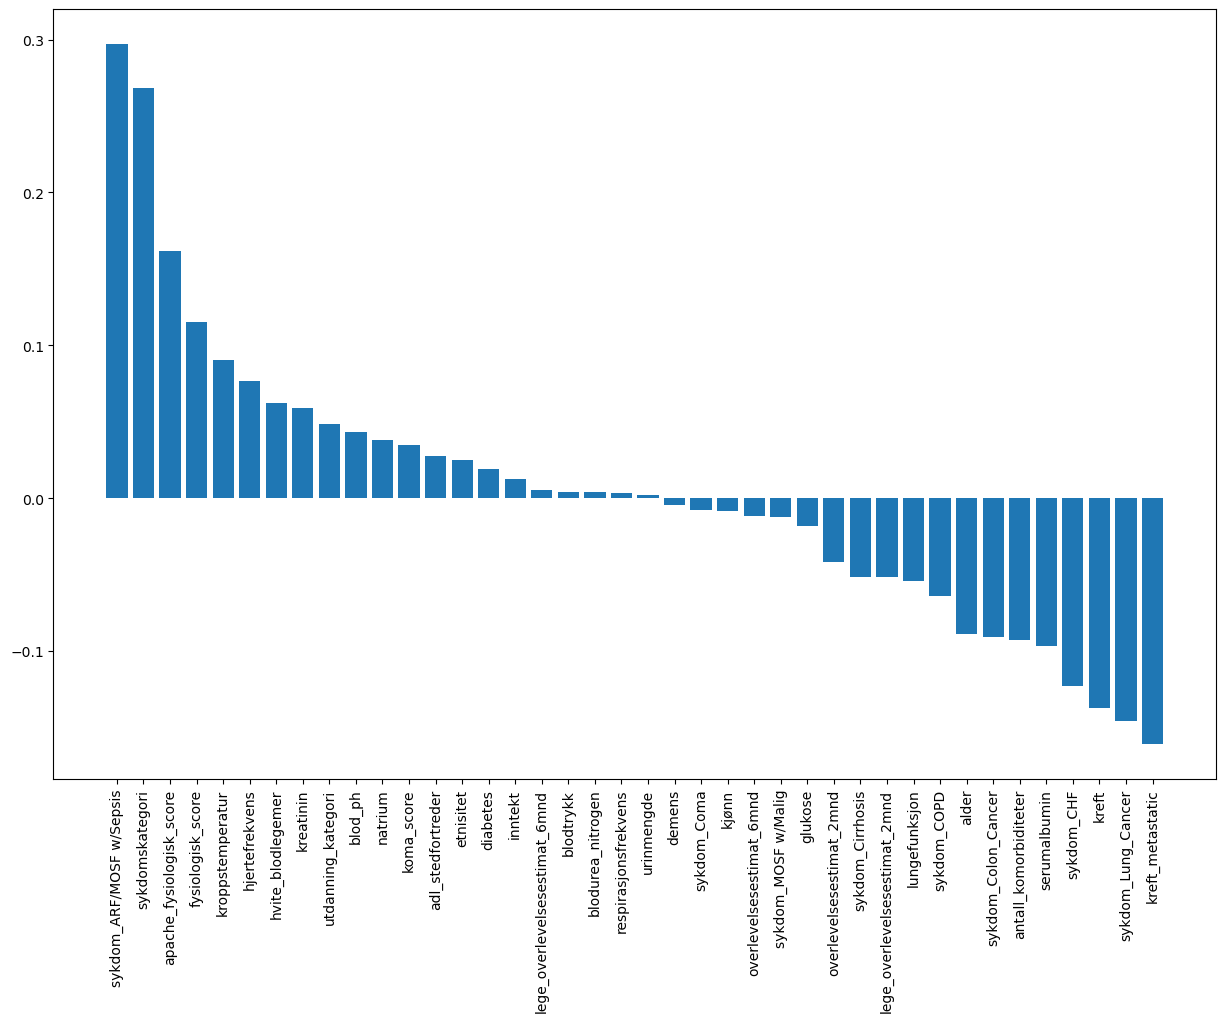

In [41]:
correlation=train_df.corr()
corr_target=correlation['oppholdslengde'].sort_values(ascending=False)
corr_target.drop('oppholdslengde', inplace=True)

plt.figure(figsize=(15,10))
plt.bar(corr_target.index, corr_target.values)
plt.xticks(rotation=90)

plt.show()

In [42]:
correlation_matrix = train_df.corr()

fig = px.imshow(correlation_matrix,
               labels=dict(x='Features', y='Features', color='Correlation'),
               x=correlation_matrix.columns,
               y=correlation_matrix.columns,
               color_continuous_scale='RdBu_r',
               aspect='auto')

fig.update_layout(
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),
    autosize=False,
    height=1000,
    width=1000
)

fig.show()


## 4.0.1 Modellering/NaN-verdier

### 4.1.1 Sammenheng mellom NaN-verdier, og utfylling

In [43]:
missing_percentages = (train_df.isnull().sum() / len(train_df)) * 100
missing_percentages

alder                             0.092370
inntekt                          33.123961
etnisitet                         0.000000
blodtrykk                         0.000000
hvite_blodlegemer                 2.438574
hjertefrekvens                    0.000000
respirasjonsfrekvens              0.000000
kroppstemperatur                  0.000000
lungefunksjon                    25.364862
serumalbumin                     36.800296
kreatinin                         0.775910
natrium                           0.000000
blod_ph                          25.013856
glukose                          49.140957
blodurea_nitrogen                47.441345
urinmengde                       52.909662
sykdomskategori                   0.000000
antall_komorbiditeter             0.000000
koma_score                        0.000000
adl_stedfortreder                31.664511
fysiologisk_score                 0.000000
apache_fysiologisk_score          0.000000
overlevelsesestimat_2mnd          0.000000
overlevelse

In [44]:
#import missingno as msno

#msno.matrix(train_df)

#plt.figure(figsize=(3, 3))
#msno.heatmap(train_df)
#plt.show()

##### Annen tilnærming for å finne sammenheng mellom NaN-verdier

In [45]:
nan_corr = train_df['blod_ph'].isna().corr(train_df['lungefunksjon'].isna())
print(f"Korrelasjonen mellom NaN-verdiene i blod_ph og lungefunksjon: {nan_corr}")

Korrelasjonen mellom NaN-verdiene i blod_ph og lungefunksjon: 0.9887690322782575


#### 4.1.2 Blod_ph og lungefunksjon

In [46]:
train_df[['blod_ph', 'lungefunksjon']].head()

,blod_ph,lungefunksjon
0,7.279297,404.000
1,7.349609,111.625
2,7.429688,112.500
3,NaN,NaN
4,7.369141,280.750


In [47]:
train_df.loc[:, 'blod_ph'] = train_df['blod_ph'].fillna(7.40)
val_df.loc[:, 'blod_ph'] = val_df['blod_ph'].fillna(7.40)
test_df.loc[:, 'blod_ph'] = test_df['blod_ph'].fillna(7.40)

In [48]:
train_df.loc[:, 'lungefunksjon'] = train_df['lungefunksjon'].fillna(333.3)
val_df.loc[:, 'lungefunksjon'] = val_df['lungefunksjon'].fillna(333.3)
test_df.loc[:, 'lungefunksjon'] = test_df['lungefunksjon'].fillna(333.3)

#### 4.1.3 Glukose og Bloduera nitrogen

In [49]:
print(train_df[['blodurea_nitrogen', 'glukose', 'diabetes']].head(n=20))

    blodurea_nitrogen  glukose  diabetes
0                 NaN      NaN         0
1                 NaN      NaN         0
2                17.0    115.0         1
3                33.0    125.0         0
4                32.0    274.0         0
5                 NaN      NaN         1
6                18.0    149.0         1
7                 NaN      NaN         0
8                 NaN      NaN         0
9                 9.0    179.0         0
10              119.0     82.0         0
11                NaN      NaN         0
12               28.0    246.0         0
13               12.0    199.0         0
14                9.0    100.0         0
15               55.0    100.0         0
16                NaN      NaN         0
17               12.0      NaN         0
18                NaN      NaN         0
19                NaN      NaN         0


In [50]:
train_df.loc[:, 'blodurea_nitrogen'] = train_df['blodurea_nitrogen'].fillna(6.51)
val_df.loc[:, 'blodurea_nitrogen'] = val_df['blodurea_nitrogen'].fillna(6.51)
test_df.loc[:, 'blodurea_nitrogen'] = test_df['blodurea_nitrogen'].fillna(6.51)

In [51]:
train_df.loc[:, 'glukose'] = train_df['glukose'].fillna(85)
val_df.loc[:, 'glukose'] = val_df['glukose'].fillna(85)
test_df.loc[:, 'glukose'] = test_df['glukose'].fillna(85)

#### 4.1.4 Urinmengde

In [52]:
train_df.loc[:, 'urinmengde'] = train_df['urinmengde'].fillna(2502)
val_df.loc[:, 'urinmengde'] = val_df['urinmengde'].fillna(2502)
test_df.loc[:, 'urinmengde'] = test_df['urinmengde'].fillna(2502)

In [53]:
train_df

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,oppholdslengde,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.0,0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,85.0,6.51,2502.0,1,3,0.0,0.0,21.097656,17.0,0.732910,0.580933,0,0,0.90,0.900,5,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0
1,65.26495,1.0,0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,85.0,6.51,2502.0,1,5,44.0,0.0,46.898438,71.0,0.046997,0.004999,0,0,0.10,0.001,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
2,71.98395,NaN,0,115.0,10.500000,74.0,22.0,38.09375,112.5000,NaN,1.699951,137.0,7.429688,115.0,17.00,2095.0,4,3,0.0,0.0,20.398438,26.0,0.741943,0.661987,1,0,0.90,0.900,45,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
3,52.26599,3.0,2,77.0,10.398438,60.0,20.0,35.59375,333.3000,NaN,1.699951,135.0,7.400000,125.0,33.00,1150.0,2,1,0.0,0.0,37.195312,22.0,0.404968,0.106995,0,0,NaN,NaN,19,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,NaN
4,69.77100,3.0,0,57.0,16.898438,165.0,40.0,38.19531,280.7500,NaN,1.299805,138.0,7.369141,274.0,32.00,1250.0,2,1,0.0,0.0,5.599609,9.0,0.865967,0.700928,0,0,NaN,NaN,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.0,0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,85.0,6.51,2502.0,1,7,0.0,0.0,11.898438,13.0,0.934937,0.889893,0,0,0.80,0.700,7,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
5409,81.90594,0.0,0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,85.0,6.51,2502.0,1,3,0.0,5.0,13.298828,29.0,0.852905,0.756958,0,0,0.90,0.900,33,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
5410,60.37000,3.0,0,73.0,10.000000,80.0,20.0,38.50000,333.3000,NaN,0.699951,136.0,7.400000,99.0,6.00,3550.0,2,1,0.0,0.0,13.798828,11.0,0.861938,0.691895,0,0,0.80,0.500,6,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0
5411,80.05499,1.0,0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.00,3325.0,1,3,0.0,1.0,27.898438,57.0,0.605957,0.416992,0,0,0.95,0.800,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


## 4.2.1 Fyller inn NaN-verdier som er MAR (missing at random)

##### Må dele opp train, val og test igjen først. 

In [54]:
X_train = train_df.drop(columns=['oppholdslengde']) 
y_train = train_df['oppholdslengde']                 

X_val = val_df.drop(columns=['oppholdslengde'])      
y_val = val_df['oppholdslengde']                     

X_test = test_df.drop(columns=['oppholdslengde'])    
y_test = test_df['oppholdslengde']     


X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
y_val_copy = y_val.copy()
X_val_copy = X_val.copy()

#### 4.2.2 Optimalisering av imputasjonsmetode for NaN-verdier i den beste modellen.

In [55]:
extraTree = ExtraTreesRegressor(max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400, random_state=42)
mlp = MLPRegressor(activation='relu', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001, solver='adam', max_iter=500, random_state=42)
gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, subsample=1.0, alpha=0.9, random_state=42)
lasso=Lasso(alpha=0.1, random_state=42)


param_grids = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [400],
        'model__max_depth': [20],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [5],
        'model__max_features': [0.5]
    },
    'GradientBoostingRegressor': {
        'model__n_estimators': [100],  
        'model__learning_rate': [0.1],
        'model__max_depth': [3],
        'model__max_features': ['log2'],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [5],
        'model__subsample': [1.0],
        'model__alpha': [0.9]
    },
    'MLPRegressor': {
        'model__activation': ['relu'],
        'model__alpha': [0.001],
        'model__hidden_layer_sizes': [(100,)],
        'model__learning_rate': ['constant'],
        'model__learning_rate_init': [0.001],
        'model__solver': ['adam'],
        'model__max_iter': [500]
    },
    'Lasso': { 
        'model__alpha': [0.1]
    }
}

imputers = {
    'SimpleMean': SimpleImputer(strategy='mean'),
    'SimpleMedian': SimpleImputer(strategy='median'),
    'SimpleMostFrequent': SimpleImputer(strategy='most_frequent'),
    'KNN50': KNNImputer(n_neighbors=50),
    'KNN100': KNNImputer(n_neighbors=100),
    'KNN150': KNNImputer(n_neighbors=150),  
}

if run_grid_search_forAll:
    models = [
        ('ExtraTreesRegressor', extraTree),
        ('GradientBoostingRegressor', gradient),
        ('MLPRegressor', mlp),
        ('Lasso', lasso)
    ]
    results = []

    for imputer_name, imputer in imputers.items():
        for model_name, model in models:

            pipeline = Pipeline([
                ('imputer', imputer),
                ('model', model)
            ])

            param_grid = param_grids[model_name]
            cv=KFold(n_splits=5, shuffle=True, random_state=42)

            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=cv,  
                scoring='neg_root_mean_squared_error',
                n_jobs=-1, 
                verbose=1
            )

            if imputer_name.startswith("KNN"):
                imputer_transformer = KNNImputer(n_neighbors=int(imputer_name.replace('KNN', '')))
            else:
                imputer_transformer = imputer

            X_train_imputed = imputer_transformer.fit_transform(X_train_copy)
            X_val_imputed = imputer_transformer.transform(X_val_copy)

            X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_copy.columns)
            X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val_copy.columns)

            grid_search.fit(X_train_imputed, y_train_copy)

            best_model = grid_search.best_estimator_

            y_pred = best_model.predict(X_val_imputed)

            rmse = np.sqrt(mean_squared_error(y_val_copy, y_pred))

            results.append({
                'Imputer': imputer_name,
                'Model': model_name,
                'Best Params': grid_search.best_params_,
                'RMSE': rmse
            })
    results_df = pd.DataFrame(results).sort_values(by='RMSE')
    
    results_df_clean = results_df[['Imputer', 'Model', 'RMSE']].sort_values(by='RMSE')
    print(results_df_clean)



#### Finner best imputasjon for NaN-verdier, MAR. 

In [56]:
if fill_in_mean:
    imputer = SimpleImputer(strategy='mean')

    X_train = imputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=train_df.drop('oppholdslengde', axis=1).columns)

    X_val = imputer.transform(X_val)
    X_val = pd.DataFrame(X_val, columns=val_df.drop('oppholdslengde', axis=1).columns)

    X_test = imputer.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=test_df.drop('oppholdslengde', axis=1).columns)

    train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    val_df = pd.concat([X_val, y_val.reset_index(drop=True)], axis=1)
    test_df = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)


In [57]:
if fill_in_knn:
    imputer = KNNImputer(n_neighbors=100) 

    X_train = imputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=train_df.drop('oppholdslengde', axis=1).columns)

    X_val = imputer.transform(X_val)
    X_val = pd.DataFrame(X_val, columns=val_df.drop('oppholdslengde', axis=1).columns)

    X_test = imputer.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=test_df.drop('oppholdslengde', axis=1).columns)

    train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    val_df = pd.concat([X_val, y_val.reset_index(drop=True)], axis=1)
    test_df = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

    X_train['inntekt'] = X_train['inntekt'].round().astype('int64')
    X_val['inntekt'] = X_val['inntekt'].round().astype('int64')
    X_test['inntekt'] = X_test['inntekt'].round().astype('int64')


X_train.isnull().sum()


alder                            0
inntekt                          0
etnisitet                        0
blodtrykk                        0
hvite_blodlegemer                0
hjertefrekvens                   0
respirasjonsfrekvens             0
kroppstemperatur                 0
lungefunksjon                    0
serumalbumin                     0
kreatinin                        0
natrium                          0
blod_ph                          0
glukose                          0
blodurea_nitrogen                0
urinmengde                       0
sykdomskategori                  0
antall_komorbiditeter            0
koma_score                       0
adl_stedfortreder                0
fysiologisk_score                0
apache_fysiologisk_score         0
overlevelsesestimat_2mnd         0
overlevelsesestimat_6mnd         0
diabetes                         0
demens                           0
lege_overlevelsesestimat_2mnd    0
lege_overlevelsesestimat_6mnd    0
kjønn               

## 4.3.1 Modellering, identifisering av den beste modellen

#### 4.3.2 Grunnlinjemodell

In [58]:
baseline = DummyRegressor(strategy='mean') 
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_val)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
 
score = {}
score["actual"] = y_val
score["baseline"] = y_pred_baseline 

print(f"RMSE for baseline: {rmse_baseline}")

RMSE for baseline: 20.603790732142762


#### 4.3.3 Tester ulike modeller

In [59]:
models = [tree.DecisionTreeRegressor(random_state=42), ensemble.GradientBoostingRegressor(random_state=42), ensemble.ExtraTreesRegressor(random_state=42), 
          ensemble.RandomForestRegressor(random_state=42),neural_network.MLPRegressor(random_state=42),linear_model.Lasso(random_state=42)]

bestmodel = []
best_rmse = rmse_baseline

for reg in models:
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_val) 
    reg_score = float(np.sqrt(metrics.mean_squared_error(y_val, reg_pred)))
    if reg_score <= best_rmse:
        best_rmse = reg_score
        bestmodel = reg    
    print("model: " + str(reg) + " , score is " + str(reg_score))
print("best model: " + str(bestmodel) + " , score is " + str(best_rmse))

model: DecisionTreeRegressor(random_state=42) , score is 31.413784586849218
model: GradientBoostingRegressor(random_state=42) , score is 19.265632714052686
model: ExtraTreesRegressor(random_state=42) , score is 19.408581744806277
model: RandomForestRegressor(random_state=42) , score is 20.106336689864886
model: MLPRegressor(random_state=42) , score is 19.53534339699014
model: Lasso(random_state=42) , score is 19.51441568496925
best model: GradientBoostingRegressor(random_state=42) , score is 19.265632714052686


#### 4.3.4  Grunnlinjemodell Log

In [60]:
train_df['oppholdslengde_log'] = np.log(train_df['oppholdslengde']) 

fig = px.box(train_df, x='oppholdslengde_log', title="Box Plot of 'Log-Transformert oppholdslengde' kolonne")

fig.show()

In [61]:
y_train_log = np.log(y_train)

baseline_log = DummyRegressor(strategy='mean') 
baseline_log.fit(X_train, y_train_log)

y_pred_log = baseline_log.predict(X_val)
y_pred = np.exp(y_pred_log)  
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred))
mae_log = mean_absolute_error(y_val, y_pred)

print(f"RMSE med log-transformasjon: {rmse_log}")

RMSE med log-transformasjon: 21.300741520701333


#### Tester flere modeller for Log-transformasjon. 

In [62]:
y_train_log = np.log(y_train)

models = [
    tree.DecisionTreeRegressor(random_state=42),
    ensemble.GradientBoostingRegressor(random_state=42),
    ensemble.ExtraTreesRegressor(random_state=42),
    ensemble.RandomForestRegressor(random_state=42),
    neural_network.MLPRegressor(random_state=42),
    linear_model.Lasso(random_state=42)
]

bestmodel = None
best_rmse = rmse_log

X_val = pd.DataFrame(X_val, columns=X_train.columns)

for reg in models:
    reg.fit(X_train, y_train_log)  
    reg_pred_log = reg.predict(X_val)  
    reg_pred = np.exp(reg_pred_log) 

    reg_score = np.sqrt(metrics.mean_squared_error(y_val, reg_pred))

    if reg_score <= best_rmse:
        best_rmse = reg_score
        bestmodel = reg

    print(f"Model: {str(reg)} , RMSE: {reg_score}")

print(f"The best model is: {str(bestmodel)} with RMSE: {best_rmse}")


Model: DecisionTreeRegressor(random_state=42) , RMSE: 28.861933526646332
Model: GradientBoostingRegressor(random_state=42) , RMSE: 19.59610539834165
Model: ExtraTreesRegressor(random_state=42) , RMSE: 19.267115296694392
Model: RandomForestRegressor(random_state=42) , RMSE: 19.3938273944356
Model: MLPRegressor(random_state=42) , RMSE: 146.19725416265572
Model: Lasso(random_state=42) , RMSE: 21.11537273789782
The best model is: ExtraTreesRegressor(random_state=42) with RMSE: 19.267115296694392


## 4.3.5 Hyperparameter-tuning


#### 4.3.6 ExtraTreeRegressor

In [63]:
if extraTrees_first: 
    param_grid = {
        'n_estimators': [400],
        'max_depth': [20],
        'min_samples_split': [2], 
        'min_samples_leaf': [5],  
        'max_features': [0.5],
    }

    model = ExtraTreesRegressor(random_state=42)
    
    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,  
        n_jobs=-1, 
        verbose=1,
        scoring='neg_root_mean_squared_error'
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    best_model_Et = grid_search.best_estimator_
    y_pred_et = best_model_Et.predict(X_val)

    rmse_et = np.sqrt(mean_squared_error(y_val, y_pred_et))
    print(f"RMSE på valideringssettet: {rmse_et}")

In [64]:
if extraTrees_first:
    df = pd.DataFrame({
    'Faktisk oppholdslengde': y_val,
    'Predikert oppholdslengde (ExtraTreesRegressor)': y_pred_et,
    'Predikert oppholdslengde (Baseline)': y_pred_baseline
})


    fig_etr = px.scatter(df, 
                    x='Faktisk oppholdslengde', 
                    y='Predikert oppholdslengde (ExtraTreesRegressor)', 
                    labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde'},
                    title='Faktisk vs. Predikert oppholdslengde (ExtraTreesRegressor)')
    

    fig_etr.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                 line=dict(color='red', dash='dash'))

    fig_etr.add_annotation(
        xref="paper", yref="paper",
        x=0.05, y=1.1,  
        showarrow=False,
        text="Blå prikker = predikerte verdier, Rød linje = perfekt prediksjon"
    )

    fig_etr.show()




In [65]:
model=ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400, random_state=42)


model.fit(X_train, y_train)
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))

                      Feature  Importance
     sykdom_ARF/MOSF w/Sepsis    0.147720
              sykdomskategori    0.059978
     overlevelsesestimat_2mnd    0.050533
     overlevelsesestimat_6mnd    0.048260
     apache_fysiologisk_score    0.042568
lege_overlevelsesestimat_2mnd    0.040237
                        alder    0.038227
            fysiologisk_score    0.037538
lege_overlevelsesestimat_6mnd    0.034762
           utdanning_kategori    0.031200
            adl_stedfortreder    0.031010
                   koma_score    0.028725
                        kjønn    0.028434
         respirasjonsfrekvens    0.025584
                      natrium    0.024714
                    blodtrykk    0.023087
                 serumalbumin    0.023057
        antall_komorbiditeter    0.023044
                      inntekt    0.022585
                lungefunksjon    0.021462
             kroppstemperatur    0.021459
               hjertefrekvens    0.020238
                    kreatinin    0

#### 4.3.7 GradientBoosting

In [66]:
if gradientBoosting_first:
    param_grid = {
        'learning_rate': [0.1], 
        'max_depth': [3], 
        'max_features': ['log2'], 
        'min_samples_leaf': [5],  
        'min_samples_split': [2],  
        'subsample': [1.0],  
        'alpha': [0.8, 0.9]  
    }

    model = GradientBoostingRegressor(random_state=42)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1, 
        verbose=1, 
        scoring='neg_root_mean_squared_error'  
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")
    y_pred_gb = grid_search.best_estimator_.predict(X_val)
    rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
    print(f"RMSE på valideringssettet: {rmse_gb}")


##### Printer ut forhold mellom de faktiske verdiene og predikerte

In [67]:
if gradientBoosting_first:
    df_val_pred = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (GradientBoosting)': y_pred_gb,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })


    fig_gb = px.scatter(df_val_pred, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (GradientBoosting)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (GradientBoosting)'},
                        title='Faktisk vs. Predikert oppholdslengde (GradientBoosting)')

    fig_gb.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))
                    
    fig_gb.add_annotation(
        xref="paper", yref="paper",
        x=0.05, y=1.1,  
        showarrow=False,
        text="Blå prikker = predikerte verdier, Rød linje = perfekt prediksjon"
    )
    

    fig_gb.show()

In [68]:
model= GradientBoostingRegressor(random_state=42, alpha=0.9, learning_rate=0.05, loss='absolute_error', max_depth=5, max_features='sqrt', min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=1.0)

model.fit(X_train, y_train)
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))



                      Feature  Importance
              sykdomskategori    0.109922
            fysiologisk_score    0.098366
     overlevelsesestimat_2mnd    0.075036
     apache_fysiologisk_score    0.069733
     overlevelsesestimat_6mnd    0.062049
     sykdom_ARF/MOSF w/Sepsis    0.058482
            adl_stedfortreder    0.055487
lege_overlevelsesestimat_2mnd    0.050817
lege_overlevelsesestimat_6mnd    0.049160
                        alder    0.040606
           sykdom_Lung_Cancer    0.023815
                lungefunksjon    0.023287
             kroppstemperatur    0.023011
                   koma_score    0.021085
                    blodtrykk    0.020963
                   sykdom_CHF    0.018731
         respirasjonsfrekvens    0.018026
               hjertefrekvens    0.016279
            hvite_blodlegemer    0.016246
             kreft_metastatic    0.015884
                      blod_ph    0.015661
                      natrium    0.014864
                 serumalbumin    0

#### 4.3.8 Lasso-modell

In [69]:
if Lasso_first: 
    model = Lasso(random_state=42)

    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  
    }

    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        n_jobs=-1, 
        verbose=1,
        scoring='neg_root_mean_squared_error' 
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    best_model_lasso = grid_search.best_estimator_

    y_pred_lasso = best_model_lasso.predict(X_val)

    rmse_lasso = np.sqrt(mean_squared_error(y_val, y_pred_lasso))
    print(f"RMSE på valideringssettet: {rmse_lasso}")


In [70]:
if Lasso_first: 
    df_val_pred = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (Lasso)': y_pred_lasso,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline 
    })

    fig_la = px.scatter(df_val_pred, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (Lasso)',  
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (Lasso)'},
                        title='Faktisk vs. Predikert oppholdslengde (Lasso)')

    fig_la.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))
    
    fig_la.add_annotation(
        xref="paper", yref="paper",
        x=0.05, y=1.1,  
        showarrow=False,
        text="Blå prikker = predikerte verdier, Rød linje = perfekt prediksjon"
    )

    fig_la.show()

#### 4.3.9 MLP

In [71]:
if mlp_first:
    param_grid = {
        'hidden_layer_sizes': [(100,)],  
        'activation': ['relu'],  
        'solver': ['adam'],  
        'alpha': [0.001], 
        'learning_rate': ['constant'],  
        'learning_rate_init': [0.001]
    }
    
    model = MLPRegressor(max_iter=1000, random_state=42, early_stopping=True)
    cv= KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1,  
        verbose=1,  
        scoring='neg_root_mean_squared_error'  
    )
    
    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    y_pred_mlp = grid_search.best_estimator_.predict(X_val)

    rmse_mlp = np.sqrt(mean_squared_error(y_val, y_pred_mlp))
    print(f"RMSE på valideringssettet: {rmse_mlp}")

In [72]:
if mlp_first:
    val_pred_df = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (MLP)': y_pred_mlp,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })

    fig_mlp = px.scatter(val_pred_df, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (MLP)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (MLP)'},
                        title='Faktisk vs. Predikert oppholdslengde (MLP)')

    fig_mlp.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))
    
    fig_mlp.add_annotation(
        xref="paper", yref="paper",
        x=0.05, y=1.1,  
        showarrow=False,
        text="Blå prikker = predikerte verdier, Rød linje = perfekt prediksjon"
    )

    fig_mlp.show()


#### 4.4.0 Log-modell, ExtraTreesRegressor.

In [73]:
if ExtraTree_log:
    param_grid = {
        'n_estimators': [200],
        'max_depth': [50],
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'oob_score': [True, False],
        'max_features': [0.9],
        'bootstrap': [True]
    }
    
    model = ExtraTreesRegressor(random_state=42)
    cv = KFold(n_splits=4, shuffle=True, random_state=42)

    y_train_log = np.log(y_train)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,              
        n_jobs=-1,           
        verbose=1, 
        scoring= 'neg_root_mean_squared_error'
    )
    
    grid_search.fit(X_train, y_train_log)  

    print(f"Beste parametere: {grid_search.best_params_}")

    y_pred_r_log = grid_search.best_estimator_.predict(X_val)
    y_pred_r = np.exp(y_pred_r_log)  

    rmse_t = np.sqrt(mean_squared_error(y_val, y_pred_r))
    print(f"RMSE på valideringssettet: {rmse_t}")


##### Visualiserer predikerte verdi opp mot den faktiske verdien. 

In [74]:
if ExtraTree_log:
    val_pred_df = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (ExtraTree_log)': y_pred_r,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })

    fig_ExtraTree_log= px.scatter(val_pred_df, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (ExtraTree_log)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (ExtraTree_log)'},
                        title='Faktisk vs. Predikert oppholdslengde (ExtraTree_log)')

    fig_ExtraTree_log.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))
    

    fig_ExtraTree_log.add_annotation(
        xref="paper", yref="paper",
        x=0.05, y=1.1,  
        showarrow=False,
        text="Blå prikker = predikerte verdier, Rød linje = perfekt prediksjon"
    )

    fig_ExtraTree_log.show()    


In [75]:
model= ExtraTreesRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, oob_score=True, max_features=0.9, bootstrap=True,random_state=42)

y_train_log = np.log(y_train)
model.fit(X_train, y_train_log)

model.fit(X_train, y_train)
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))

                      Feature  Importance
     sykdom_ARF/MOSF w/Sepsis    0.112578
     overlevelsesestimat_2mnd    0.041929
     apache_fysiologisk_score    0.041191
                        alder    0.040448
     overlevelsesestimat_6mnd    0.037932
            fysiologisk_score    0.037063
            adl_stedfortreder    0.035997
lege_overlevelsesestimat_6mnd    0.035647
lege_overlevelsesestimat_2mnd    0.035571
           utdanning_kategori    0.033999
                      natrium    0.033114
                    blodtrykk    0.032659
         respirasjonsfrekvens    0.030952
                   koma_score    0.030757
            hvite_blodlegemer    0.029768
                 serumalbumin    0.029579
             kroppstemperatur    0.028508
                    kreatinin    0.028421
        antall_komorbiditeter    0.027694
                      blod_ph    0.026736
                lungefunksjon    0.026722
               hjertefrekvens    0.026512
                      inntekt    0

#### 4.4.1 Samler alle modeller, oversikt. 

In [76]:
extraTree = ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400, random_state=42)
Lasso = Lasso(alpha=0.001, random_state=42)
mlp = MLPRegressor(activation='relu', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001,random_state=42)
gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, subsample=1.0, random_state=42)
ExtraTree_log = ExtraTreesRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, oob_score=True, max_features=0.9, bootstrap=True,random_state=42)

models = {
    'ExtraTreesRegressor': extraTree,
    'MLPRegressor': mlp,
    'GradientBoostingRegressor': gradient,
    'ExtraTree_Log': ExtraTree_log,  
    'Lasso': Lasso
}

model_rmse = {}

for name, model in models.items():
    if name == 'ExtraTree_Log': 
        y_train_log = np.log(y_train)
        model.fit(X_train, y_train_log)
        y_pred_log = model.predict(X_val)
        y_pred = np.exp(y_pred_log)  
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    model_rmse[name] = rmse  
    print(f"{name} - RMSE: {rmse:.4f}")

best_model_name = min(model_rmse, key=model_rmse.get)
best_rmse = model_rmse[best_model_name]

print(f"\nBeste modell basert på RMSE på valideringssettet: {best_model_name} med RMSE: {best_rmse:.4f}")

ExtraTreesRegressor - RMSE: 18.6554
MLPRegressor - RMSE: 20.9470
GradientBoostingRegressor - RMSE: 19.0255
ExtraTree_Log - RMSE: 19.3106
Lasso - RMSE: 19.2726

Beste modell basert på RMSE på valideringssettet: ExtraTreesRegressor med RMSE: 18.6554


/Users/asegrethe/miniconda3/envs/INF161/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.548e+05, tolerance: 2.535e+02



#### 4.4.2 Overfitting

In [77]:
models = {
    'ExtraTree_log': ExtraTree_log,
    'ExtraTreesRegressor': extraTree,
    'GradientBoostingRegressor': gradient,
    'MLPRegressor': mlp,
    'Lasso':Lasso
}
train_rmse_scores = {}
val_rmse_scores = {}

for name, model in models.items():
    print(f"Training model: {name}")
    
    if 'Log' in name:
        y_train_log = np.log(y_train)
        y_val_log = np.log(y_val)
        model.fit(X_train, y_train_log)
        
        y_train_pred_log = model.predict(X_train)
        y_val_pred_log = model.predict(X_val)
        
        y_train_pred = np.exp(y_train_pred_log)
        y_val_pred = np.exp(y_val_pred_log)
    else:
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_rmse_scores[name] = train_rmse
    val_rmse_scores[name] = val_rmse

    print(f"{name} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")

Training model: ExtraTree_log
ExtraTree_log - Training RMSE: 11.9152, Validation RMSE: 18.9672
Training model: ExtraTreesRegressor
ExtraTreesRegressor - Training RMSE: 14.0232, Validation RMSE: 18.6554
Training model: GradientBoostingRegressor
GradientBoostingRegressor - Training RMSE: 18.7349, Validation RMSE: 19.0255
Training model: MLPRegressor
MLPRegressor - Training RMSE: 21.2000, Validation RMSE: 20.9470
Training model: Lasso
Lasso - Training RMSE: 20.0702, Validation RMSE: 19.2726


/Users/asegrethe/miniconda3/envs/INF161/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.548e+05, tolerance: 2.535e+02



In [78]:
rmse_data = pd.DataFrame({
    'Model': list(train_rmse_scores.keys()),
    'Train RMSE': list(train_rmse_scores.values()),
    'Validation RMSE': list(val_rmse_scores.values())
})

rmse_melted = rmse_data.melt(id_vars='Model', value_vars=['Train RMSE', 'Validation RMSE'], 
                             var_name='Type', value_name='RMSE')

fig = px.bar(rmse_melted, x='Model', y='RMSE', color='Type', barmode='group', title="Overfitting i modellene")

fig.show()

##  5.0.1 Variabelutvinning

In [79]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.000000,0.0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,85.0,6.51,2502.0,1.0,3.0,0.0,0.0,21.097656,17.0,0.732910,0.580933,0.0,0.0,0.900000,0.900000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
1,65.26495,1.000000,0.0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,85.0,6.51,2502.0,1.0,5.0,44.0,0.0,46.898438,71.0,0.046997,0.004999,0.0,0.0,0.100000,0.001000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
2,71.98395,0.936188,0.0,115.0,10.500000,74.0,22.0,38.09375,112.5000,2.941227,1.699951,137.0,7.429688,115.0,17.00,2095.0,4.0,3.0,0.0,0.0,20.398438,26.0,0.741943,0.661987,1.0,0.0,0.900000,0.900000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00000
3,52.26599,3.000000,2.0,77.0,10.398438,60.0,20.0,35.59375,333.3000,2.941227,1.699951,135.0,7.400000,125.0,33.00,1150.0,2.0,1.0,0.0,0.0,37.195312,22.0,0.404968,0.106995,0.0,0.0,0.615295,0.494693,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.76368
4,69.77100,3.000000,0.0,57.0,16.898438,165.0,40.0,38.19531,280.7500,2.941227,1.299805,138.0,7.369141,274.0,32.00,1250.0,2.0,1.0,0.0,0.0,5.599609,9.0,0.865967,0.700928,0.0,0.0,0.615295,0.494693,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.000000,0.0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,85.0,6.51,2502.0,1.0,7.0,0.0,0.0,11.898438,13.0,0.934937,0.889893,0.0,0.0,0.800000,0.700000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
5409,81.90594,0.000000,0.0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,85.0,6.51,2502.0,1.0,3.0,0.0,5.0,13.298828,29.0,0.852905,0.756958,0.0,0.0,0.900000,0.900000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.76368
5410,60.37000,3.000000,0.0,73.0,10.000000,80.0,20.0,38.50000,333.3000,2.941227,0.699951,136.0,7.400000,99.0,6.00,3550.0,2.0,1.0,0.0,0.0,13.798828,11.0,0.861938,0.691895,0.0,0.0,0.800000,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.00000
5411,80.05499,1.000000,0.0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.00,3325.0,1.0,3.0,0.0,1.0,27.898438,57.0,0.605957,0.416992,0.0,0.0,0.950000,0.800000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000


#### 5.0.2 Analyse av korte og lange opphold. 

In [80]:
df_train = X_train.copy()  
df_train['oppholdslengde'] = y_train  

short_stays = df_train[df_train['oppholdslengde'] <= 100].copy()  
long_stays = df_train[df_train['oppholdslengde'] > 100].copy()  

short_stay_summary = short_stays.select_dtypes(include=[np.number]).mean()
long_stay_summary = long_stays.select_dtypes(include=[np.number]).mean()

comparison = pd.DataFrame({
    'Long Stay Mean': long_stay_summary,
    'Short Stay Mean': short_stay_summary
})

print(comparison.sort_values(by='Long Stay Mean', ascending=False))



                               Long Stay Mean  Short Stay Mean
urinmengde                        2291.811765      2358.361127
lungefunksjon                      235.127610       262.469666
natrium                            139.200000       137.560435
oppholdslengde                     133.188235        16.043544
glukose                            116.094118       123.067380
hjertefrekvens                     105.682353        97.567192
blodtrykk                           83.552941        84.221378
alder                               58.026260        62.800913
apache_fysiologisk_score            49.529412        37.445383
kroppstemperatur                    37.363604        37.141792
fysiologisk_score                   29.939384        25.457002
respirasjonsfrekvens                23.329412        23.485360
blodurea_nitrogen                   18.481529        19.974577
koma_score                          14.188235        12.412538
hvite_blodlegemer                   13.557767        12

#### 5.0.5 Binære variabler. 

In [81]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.000000,0.0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,85.0,6.51,2502.0,1.0,3.0,0.0,0.0,21.097656,17.0,0.732910,0.580933,0.0,0.0,0.900000,0.900000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
1,65.26495,1.000000,0.0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,85.0,6.51,2502.0,1.0,5.0,44.0,0.0,46.898438,71.0,0.046997,0.004999,0.0,0.0,0.100000,0.001000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
2,71.98395,0.936188,0.0,115.0,10.500000,74.0,22.0,38.09375,112.5000,2.941227,1.699951,137.0,7.429688,115.0,17.00,2095.0,4.0,3.0,0.0,0.0,20.398438,26.0,0.741943,0.661987,1.0,0.0,0.900000,0.900000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00000
3,52.26599,3.000000,2.0,77.0,10.398438,60.0,20.0,35.59375,333.3000,2.941227,1.699951,135.0,7.400000,125.0,33.00,1150.0,2.0,1.0,0.0,0.0,37.195312,22.0,0.404968,0.106995,0.0,0.0,0.615295,0.494693,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.76368
4,69.77100,3.000000,0.0,57.0,16.898438,165.0,40.0,38.19531,280.7500,2.941227,1.299805,138.0,7.369141,274.0,32.00,1250.0,2.0,1.0,0.0,0.0,5.599609,9.0,0.865967,0.700928,0.0,0.0,0.615295,0.494693,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.000000,0.0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,85.0,6.51,2502.0,1.0,7.0,0.0,0.0,11.898438,13.0,0.934937,0.889893,0.0,0.0,0.800000,0.700000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
5409,81.90594,0.000000,0.0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,85.0,6.51,2502.0,1.0,3.0,0.0,5.0,13.298828,29.0,0.852905,0.756958,0.0,0.0,0.900000,0.900000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.76368
5410,60.37000,3.000000,0.0,73.0,10.000000,80.0,20.0,38.50000,333.3000,2.941227,0.699951,136.0,7.400000,99.0,6.00,3550.0,2.0,1.0,0.0,0.0,13.798828,11.0,0.861938,0.691895,0.0,0.0,0.800000,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.00000
5411,80.05499,1.000000,0.0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.00,3325.0,1.0,3.0,0.0,1.0,27.898438,57.0,0.605957,0.416992,0.0,0.0,0.950000,0.800000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000


In [82]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,74.12500,0.000000,0.0,77.0,8.898438,60.0,24.0,36.29688,404.0000,2.599609,0.899902,139.0,7.279297,85.0,6.51,2502.0,1.0,3.0,0.0,0.0,21.097656,17.0,0.732910,0.580933,0.0,0.0,0.900000,0.900000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
1,65.26495,1.000000,0.0,46.0,18.500000,160.0,38.0,39.00000,111.6250,2.799805,1.500000,131.0,7.349609,85.0,6.51,2502.0,1.0,5.0,44.0,0.0,46.898438,71.0,0.046997,0.004999,0.0,0.0,0.100000,0.001000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
2,71.98395,0.936188,0.0,115.0,10.500000,74.0,22.0,38.09375,112.5000,2.941227,1.699951,137.0,7.429688,115.0,17.00,2095.0,4.0,3.0,0.0,0.0,20.398438,26.0,0.741943,0.661987,1.0,0.0,0.900000,0.900000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00000
3,52.26599,3.000000,2.0,77.0,10.398438,60.0,20.0,35.59375,333.3000,2.941227,1.699951,135.0,7.400000,125.0,33.00,1150.0,2.0,1.0,0.0,0.0,37.195312,22.0,0.404968,0.106995,0.0,0.0,0.615295,0.494693,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.76368
4,69.77100,3.000000,0.0,57.0,16.898438,165.0,40.0,38.19531,280.7500,2.941227,1.299805,138.0,7.369141,274.0,32.00,1250.0,2.0,1.0,0.0,0.0,5.599609,9.0,0.865967,0.700928,0.0,0.0,0.615295,0.494693,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.000000,0.0,117.0,11.398438,76.0,24.0,35.79688,345.6875,4.299805,1.199951,137.0,7.359375,85.0,6.51,2502.0,1.0,7.0,0.0,0.0,11.898438,13.0,0.934937,0.889893,0.0,0.0,0.800000,0.700000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
5409,81.90594,0.000000,0.0,103.0,10.199219,64.0,16.0,36.09375,281.8750,4.500000,1.199951,134.0,7.489258,85.0,6.51,2502.0,1.0,3.0,0.0,5.0,13.298828,29.0,0.852905,0.756958,0.0,0.0,0.900000,0.900000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.76368
5410,60.37000,3.000000,0.0,73.0,10.000000,80.0,20.0,38.50000,333.3000,2.941227,0.699951,136.0,7.400000,99.0,6.00,3550.0,2.0,1.0,0.0,0.0,13.798828,11.0,0.861938,0.691895,0.0,0.0,0.800000,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.00000
5411,80.05499,1.000000,0.0,127.0,8.099609,102.0,38.0,37.79688,138.7500,3.099609,1.699951,147.0,7.479492,164.0,32.00,3325.0,1.0,3.0,0.0,1.0,27.898438,57.0,0.605957,0.416992,0.0,0.0,0.950000,0.800000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000


###### Glukose

In [83]:
if binære_variabler:
    X_train['glukose'] = pd.cut(X_train['glukose'],
                                bins=[-float('inf'), 70, 100, float('inf')],
                                labels=[1, 0, 1], ordered=False)
    X_train['glukose'] = X_train['glukose'].astype(float)

    X_val['glukose'] = pd.cut(X_val['glukose'],
                              bins=[-float('inf'), 70, 100, float('inf')],
                              labels=[1, 0, 1], ordered=False)
    X_val['glukose'] = X_val['glukose'].astype(float)

    X_test['glukose'] = pd.cut(X_test['glukose'],
                               bins=[-float('inf'), 70, 100, float('inf')],
                               labels=[1, 0, 1], ordered=False)
    X_test['glukose'] = X_test['glukose'].astype(float)


##### Bloduera_nitrogen

In [84]:
if binære_variabler:
    X_train['blodurea_nitrogen'] = pd.cut(X_train['blodurea_nitrogen'],
                             bins=[-float('inf'), 6, 24, float('inf')],
                             labels=[1, 0, 1], ordered=False)
    X_train['blodurea_nitrogen'] = X_train['blodurea_nitrogen'].astype(float)

    X_val['blodurea_nitrogen'] = pd.cut(X_val['blodurea_nitrogen'],
                           bins=[-float('inf'), 6, 24, float('inf')],
                           labels=[1, 0, 1], ordered=False)
    X_val['blodurea_nitrogen'] = X_val['blodurea_nitrogen'].astype(float)
    
    X_test['blodurea_nitrogen'] = pd.cut(X_test['blodurea_nitrogen'],
                            bins=[-float('inf'), 6, 24, float('inf')],
                            labels=[1, 0, 1], ordered=False)
    X_test['blodurea_nitrogen'] = X_test['blodurea_nitrogen'].astype(float)

##### Urinmengde

In [85]:
if binære_variabler:
    X_train['urinmengde'] = pd.cut(X_train['urinmengde'],
                                bins=[-float('inf'), 2500, 2502, float('inf')],
                                labels=[1, 0, 1], ordered=False)
    X_train['urinmengde'] = X_train['urinmengde'].astype(float)
    
    X_val['urinmengde'] = pd.cut(X_val['urinmengde'],
                              bins=[-float('inf'), 2500, 2502, float('inf')],
                              labels=[1, 0, 1], ordered=False)
    val_df['urinmengde'] = X_val['urinmengde'].astype(float)
    
    X_test['urinmengde'] = pd.cut(X_test['urinmengde'],
                               bins=[-float('inf'), 2500, 2502, float('inf')],
                               labels=[1, 0, 1], ordered=False)
    X_test['urinmengde'] = X_test['urinmengde'].astype(float)

##### Blod_ph

In [86]:
if binære_variabler:
    X_train['blod_ph'] = pd.cut(X_train['blod_ph'],
                             bins=[-float('inf'), 7.35, 7.45, float('inf')],
                             labels=[1, 0, 1], ordered=False)
    X_train['blod_ph'] = X_train['blod_ph'].astype(float)
    
    X_val['blod_ph'] = pd.cut(X_val['blod_ph'],
                           bins=[-float('inf'), 7.35, 7.45, float('inf')],
                           labels=[1, 0, 1], ordered=False)
    X_val['blod_ph'] = X_val['blod_ph'].astype(float)
    
    X_test['blod_ph'] = pd.cut(X_test['blod_ph'],
                            bins=[-float('inf'), 7.35, 7.45, float('inf')],
                            labels=[1, 0, 1], ordered=False)
    X_test['blod_ph'] = X_test['blod_ph'].astype(float)

In [87]:
if binære_variabler:
    
    X_train['lungefunksjon'] = pd.cut(X_train['lungefunksjon'], 
                                       bins=[-float('inf'), 300, float('inf')], 
                                       labels=[1, 0], 
                                       include_lowest=True)
    X_val['lungefunksjon'] = pd.cut(X_val['lungefunksjon'], 
                                     bins=[-float('inf'), 300, float('inf')], 
                                     labels=[1, 0], 
                                     include_lowest=True)
    X_test['lungefunksjon'] = pd.cut(X_test['lungefunksjon'], 
                                      bins=[-float('inf'), 300, float('inf')], 
                                      labels=[1, 0], 
                                      include_lowest=True)
    
    X_train['lungefunksjon'] = X_train['lungefunksjon'].astype(int)
    X_val['lungefunksjon'] = X_val['lungefunksjon'].astype(int)
    X_test['lungefunksjon'] = X_test['lungefunksjon'].astype(int)

In [88]:
if binære_variabler:
    X_train['kroppstemperatur']=pd.cut(X_train['kroppstemperatur'], 
                                   bins=[-float('inf'), 36.5, 37.5, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['kroppstemperatur'] = X_train['kroppstemperatur'].astype(float)
    
    X_val['kroppstemperatur']=pd.cut(X_val['kroppstemperatur'],
                                bins=[-float('inf'), 36.5, 37.5, float('inf')],
                                labels=[1, 0, 1], ordered=False)
    X_val['kroppstemperatur'] = X_val['kroppstemperatur'].astype(float)
    
    X_test['kroppstemperatur']=pd.cut(X_test['kroppstemperatur'],
                                bins=[-float('inf'), 36.5, 37.5, float('inf')],
                                labels=[1, 0, 1], ordered=False)
    X_test['kroppstemperatur'] = X_test['kroppstemperatur'].astype(float)


In [89]:
if binære_variabler:
    X_train['hvite_blodlegemer']=pd.cut(X_train['hvite_blodlegemer'],
                                   bins=[-float('inf'), 4.5, 11, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['hvite_blodlegemer'] = X_train['hvite_blodlegemer'].astype(float)
    
    X_val['hvite_blodlegemer']=pd.cut(X_val['hvite_blodlegemer'],
                                    bins=[-float('inf'), 4.5, 11, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_val['hvite_blodlegemer'] = X_val['hvite_blodlegemer'].astype(float)
    
    X_test['hvite_blodlegemer']=pd.cut(X_test['hvite_blodlegemer'],
                                    bins=[-float('inf'), 4.5, 11, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_test['hvite_blodlegemer'] = X_test['hvite_blodlegemer'].astype(float)

In [90]:
if binære_variabler:
    X_train['kreatinin']=pd.cut(X_train['kreatinin'],
                                   bins=[-float('inf'), 0.7, 1.3, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['kreatinin'] = X_train['kreatinin'].astype(float)
    
    X_val['kreatinin']=pd.cut(X_val['kreatinin'],
                                    bins=[-float('inf'),0.7, 1.3, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_val['kreatinin'] = X_val['kreatinin'].astype(float)
    
    X_test['kreatinin']=pd.cut(X_test['kreatinin'],
                                    bins=[-float('inf'), 0.7, 1.3, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_test['kreatinin'] = X_test['kreatinin'].astype(float)

In [91]:
if binære_variabler:
    X_train['natrium']=pd.cut(X_train['natrium'],
                                   bins=[-float('inf'), 135, 145, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['natrium'] = X_train['natrium'].astype(float)
    
    X_val['natrium']=pd.cut(X_val['natrium'],
                                    bins=[-float('inf'),135, 145, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_val['natrium'] = X_val['natrium'].astype(float)
    
    X_test['natrium']=pd.cut(X_test['natrium'],
                                    bins=[-float('inf'), 135, 145, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_test['natrium'] = X_test['natrium'].astype(float)

In [92]:
if binære_variabler:
    X_train['serumalbumin']=pd.cut(X_train['serumalbumin'],
                                   bins=[-float('inf'), 3.4, 5.4, float('inf')],
                                   labels=[1, 0, 1], ordered=False)
    X_train['serumalbumin'] = X_train['serumalbumin'].astype(float)
    
    X_val['serumalbumin']=pd.cut(X_val['serumalbumin'],
                                    bins=[-float('inf'),3.4, 5.4, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_val['serumalbumin'] = X_val['serumalbumin'].astype(float)
    
    X_test['serumalbumin']=pd.cut(X_test['serumalbumin'],
                                    bins=[-float('inf'), 3.4, 5.4, float('inf')],
                                    labels=[1, 0, 1], ordered=False)
    X_test['serumalbumin'] = X_test['serumalbumin'].astype(float)

#### 5.0.6 Prøver å trene modellen på korte opphold, setter ned topp til 150 dager. 

In [93]:
if if_clip_5:
    y_train = y_train.clip(upper=150) 


In [94]:
if if_clip_5:
    fig = px.box(x=y_train, title="Box Plot for klippet y_train data (Øverste grense 150)")
    fig.show()

#### 5.0.7 Slår sammen verdier med høy korrelasjon. 

In [95]:
if merge_apache_fysiologisk_score:
    X_train['fysiologisk_score_merge'] = (X_train['fysiologisk_score'] + X_train['apache_fysiologisk_score']) / 2
    X_val['fysiologisk_score_merge'] = (X_val['fysiologisk_score'] + X_val['apache_fysiologisk_score']) / 2
    X_test['fysiologisk_score_merge'] = (X_test['fysiologisk_score'] + X_test['apache_fysiologisk_score']) / 2

    X_train.drop(columns=['fysiologisk_score', 'apache_fysiologisk_score'], inplace=True)
    X_val.drop(columns=['fysiologisk_score', 'apache_fysiologisk_score'], inplace=True)
    X_test.drop(columns=['fysiologisk_score', 'apache_fysiologisk_score'], inplace=True)

In [96]:
if merge_overlevelsesestimater:
    X_train['overlevelsesestimat'] = (X_train['overlevelsesestimat_2mnd'] + X_train['overlevelsesestimat_6mnd']) / 2
    X_val['overlevelsesestimat'] = (X_val['overlevelsesestimat_2mnd'] + X_val['overlevelsesestimat_6mnd']) / 2
    X_test['overlevelsesestimat'] = (X_test['overlevelsesestimat_2mnd'] + X_test['overlevelsesestimat_6mnd']) / 2

    X_train.drop(columns=['overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd'], inplace=True)
    X_val.drop(columns=['overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd'], inplace=True)
    X_test.drop(columns=['overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd'], inplace=True)

    X_train['lege_overlevelsesestimat'] = (X_train['lege_overlevelsesestimat_2mnd'] + X_train['lege_overlevelsesestimat_6mnd']) / 2
    X_val['lege_overlevelsesestimat'] = (X_val['lege_overlevelsesestimat_2mnd'] + X_val['lege_overlevelsesestimat_6mnd']) / 2
    X_test['lege_overlevelsesestimat'] = (X_test['lege_overlevelsesestimat_2mnd'] + X_test['lege_overlevelsesestimat_6mnd']) / 2

    X_train.drop(columns=['lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd'], inplace=True)
    X_val.drop(columns=['lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd'], inplace=True)
    X_test.drop(columns=['lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd'], inplace=True)



#### 5.0.8 Sjekker hvor mange sykdommer en har når du har et lengre opphold

In [97]:
df_train = X_train.copy()
df_train['oppholdslengde'] = y_train  

short_stays = df_train[df_train['oppholdslengde'] <= 135].copy()
long_stays = df_train[df_train['oppholdslengde'] > 135].copy()

X_train_stopshort = short_stays.drop('oppholdslengde', axis=1)  
y_train_stopshort = short_stays['oppholdslengde']  

X_train_long = long_stays.drop('oppholdslengde', axis=1)
y_train_long = long_stays['oppholdslengde']

short_stays['stay_type'] = 'Short Stay'
long_stays['stay_type'] = 'Long Stay'
combined_stays = pd.concat([short_stays, long_stays])

In [98]:
fig = px.box(combined_stays, y='stay_type', x='antall_komorbiditeter',
             title="Fordeling av Antall Komorbiditeter for Korte vs. Lange Opphold",
             labels={'stay_type': 'Type oppholdslengde', 'antall_komorbiditeter': 'Antall komorbiditeter'})
fig.show()

In [99]:
if merge_fysiologisk_komorbiditeter:
    X_train['fysiologisk_komorbiditet_mult'] = X_train['fysiologisk_score_merge'] * X_train['antall_komorbiditeter']
    X_val['fysiologisk_komorbiditet_mult'] = X_val['fysiologisk_score_merge'] * X_val['antall_komorbiditeter']
    X_test['fysiologisk_komorbiditet_mult'] = X_test['fysiologisk_score_merge'] * X_test['antall_komorbiditeter']

#### 5.0.9 Merge alder og diabetes

In [100]:
if merge_diabetes_alder:
    X_train['diabetes_alder_mult'] = X_train['diabetes'] * X_train['alder']
    X_val['diabetes_alder_mult'] = X_val['diabetes'] * X_val['alder']
    X_test['diabetes_alder_mult'] = X_test['diabetes'] * X_test['alder']

##### 5.1.0 Kombinerer funksjoner for nyre

In [101]:
if merge_nyrefunksjon:
    X_train['nyrefunksjon'] = X_train[['blodurea_nitrogen', 'kreatinin', 'natrium']].mean(axis=1)
    X_val['nyrefunksjon'] = X_val[['blodurea_nitrogen', 'kreatinin', 'natrium']].mean(axis=1)
    X_test['nyrefunksjon'] = X_test[['blodurea_nitrogen', 'kreatinin', 'natrium']].mean(axis=1)

    X_train.drop(columns=['blodurea_nitrogen', 'kreatinin', 'natrium'], inplace=True)
    X_val.drop(columns=['blodurea_nitrogen', 'kreatinin', 'natrium'], inplace=True)
    X_test.drop(columns=['blodurea_nitrogen', 'kreatinin', 'natrium'], inplace=True)

    

#### 5.1.1 Hjertefunksjon

In [102]:
if merge_hjertefunksjon:
    X_train['hjertefunksjon'] = X_train[['blodtrykk', 'hjertefrekvens']].mean(axis=1)
    X_val['hjertefunksjon'] = X_val[['blodtrykk', 'hjertefrekvens']].mean(axis=1)
    X_test['hjertefunksjon'] = X_test[['blodtrykk', 'hjertefrekvens']].mean(axis=1)

    X_train.drop(columns=['blodtrykk', 'hjertefrekvens'], inplace=True)
    X_val.drop(columns=['blodtrykk', 'hjertefrekvens'], inplace=True)
    X_test.drop(columns=['blodtrykk', 'hjertefrekvens'], inplace=True)


##### 5.1.2 lungefunksjon

In [103]:
if merge_lungefunksjon:
    X_train['lunge_blod_ph'] = X_train[['lungefunksjon', 'blod_ph']].mean(axis=1)
    X_val['lunge_blod_ph'] = X_val[['lungefunksjon', 'blod_ph']].mean(axis=1)
    X_test['lunge_blod_ph'] = X_test[['lungefunksjon', 'blod_ph']].mean(axis=1)

    X_train.drop(columns=['lungefunksjon', 'blod_ph'], inplace=True)
    X_val.drop(columns=['lungefunksjon', 'blod_ph'], inplace=True)
    X_test.drop(columns=['lungefunksjon', 'blod_ph'], inplace=True)


#### 5.1.3 Kreft og Kreft metastatic

In [104]:
if merge_cancer: 
    X_train['kreft_sammenslått'] = X_train[['kreft', 'kreft_metastatic']].max(axis=1)
    X_val['kreft_sammenslått'] = X_val[['kreft', 'kreft_metastatic']].max(axis=1)
    X_test['kreft_sammenslått'] = X_test[['kreft', 'kreft_metastatic']].max(axis=1)

    X_train.drop(columns=['kreft', 'kreft_metastatic'], inplace=True)
    X_val.drop(columns=['kreft', 'kreft_metastatic'], inplace=True)
    X_test.drop(columns=['kreft', 'kreft_metastatic'], inplace=True)



#### 5.1.4 Gjennomsnittlig oppholdslengde

In [105]:
if gjennomsnittlig_opphold_sykdom:
    train_combined = X_train.copy()
    train_combined['oppholdslengde'] = y_train

    mean_oppholdslengde = train_combined.groupby('sykdomskategori')['oppholdslengde'].mean()

    X_train['gjennomsnittlig_oppholdslengde'] = X_train['sykdomskategori'].map(mean_oppholdslengde)
    X_val['gjennomsnittlig_oppholdslengde'] = X_val['sykdomskategori'].map(mean_oppholdslengde)
    X_test['gjennomsnittlig_oppholdslengde'] = X_test['sykdomskategori'].map(mean_oppholdslengde)
X_train

,alder,inntekt,etnisitet,hvite_blodlegemer,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,blod_ph,glukose,urinmengde,sykdomskategori,antall_komorbiditeter,koma_score,adl_stedfortreder,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,utdanning_kategori,fysiologisk_score_merge,fysiologisk_komorbiditet_mult,nyrefunksjon,hjertefunksjon,kreft_sammenslått
0,74.12500,0.000000,0.0,8.898438,24.0,36.29688,404.0000,2.599609,7.279297,85.0,2502.0,1.0,3.0,0.0,0.0,0.732910,0.580933,0.0,0.0,0.900000,0.900000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00000,19.048828,57.146484,48.803301,68.5,0.0
1,65.26495,1.000000,0.0,18.500000,38.0,39.00000,111.6250,2.799805,7.349609,85.0,2502.0,1.0,5.0,44.0,0.0,0.046997,0.004999,0.0,0.0,0.100000,0.001000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,58.949219,294.746094,46.336667,103.0,0.0
2,71.98395,0.936188,0.0,10.500000,22.0,38.09375,112.5000,2.941227,7.429688,115.0,2095.0,4.0,3.0,0.0,0.0,0.741943,0.661987,1.0,0.0,0.900000,0.900000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,23.199219,69.597656,51.899984,94.5,1.0
3,52.26599,3.000000,2.0,10.398438,20.0,35.59375,333.3000,2.941227,7.400000,125.0,1150.0,2.0,1.0,0.0,0.0,0.404968,0.106995,0.0,0.0,0.615295,0.494693,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.76368,29.597656,29.597656,56.566650,68.5,1.0
4,69.77100,3.000000,0.0,16.898438,40.0,38.19531,280.7500,2.941227,7.369141,274.0,1250.0,2.0,1.0,0.0,0.0,0.865967,0.700928,0.0,0.0,0.615295,0.494693,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00000,7.299805,7.299805,57.099935,111.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,58.71597,0.000000,0.0,11.398438,24.0,35.79688,345.6875,4.299805,7.359375,85.0,2502.0,1.0,7.0,0.0,0.0,0.934937,0.889893,0.0,0.0,0.800000,0.700000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,12.449219,87.144531,48.236650,96.5,0.0
5409,81.90594,0.000000,0.0,10.199219,16.0,36.09375,281.8750,4.500000,7.489258,85.0,2502.0,1.0,3.0,0.0,5.0,0.852905,0.756958,0.0,0.0,0.900000,0.900000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.76368,21.149414,63.448242,47.236650,83.5,1.0
5410,60.37000,3.000000,0.0,10.000000,20.0,38.50000,333.3000,2.941227,7.400000,99.0,3550.0,2.0,1.0,0.0,0.0,0.861938,0.691895,0.0,0.0,0.800000,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.00000,12.399414,12.399414,47.566650,76.5,1.0
5411,80.05499,1.000000,0.0,8.099609,38.0,37.79688,138.7500,3.099609,7.479492,164.0,3325.0,1.0,3.0,0.0,1.0,0.605957,0.416992,0.0,0.0,0.950000,0.800000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,42.449219,127.347656,60.233317,114.5,1.0


#### 5.1.5 Mapper verdier

In [106]:
if map_blodtrykk:
    X_train['blod_ph'] = pd.cut(X_train['blod_ph'],
                                bins=[0, 7.35, 7.45, float('inf')], 
                                labels=[0, 1, 2], ordered=True)
    X_train['blod_ph'] = X_train['blod_ph'].astype('int64')

    X_val['blod_ph'] = pd.cut(X_val['blod_ph'],
                              bins=[0, 7.35, 7.45, float('inf')], 
                              labels=[0, 1, 2], ordered=True)
    X_val['blod_ph'] = X_val['blod_ph'].astype('int64')

    X_test['blod_ph'] = pd.cut(X_test['blod_ph'],
                               bins=[0, 7.35, 7.45, float('inf')], 
                               labels=[0, 1, 2], ordered=True)
    X_test['blod_ph'] = X_test['blod_ph'].astype('int64')

In [107]:
if map_alder:
    X_train['alder']=pd.cut(X_train['alder'],
                                    bins=[0, 20, 40, 60, 80, float('inf')], 
                                    labels = [0,1,2,3,4], ordered=False)
    X_train['alder'] = X_train['alder'].astype('int64')

    X_val['alder']=pd.cut(X_val['alder'],
                                    bins=[0, 20, 40, 60, 80, float('inf')], 
                                    labels = [0,1,2,3,4], ordered=False)
    X_val['alder'] = X_val['alder'].astype('int64')

    X_test['alder']=pd.cut(X_test['alder'],
                                    bins=[0, 20, 40, 60, 80, float('inf')], 
                                    labels = [0,1,2,3,4], ordered=False)
    X_test['alder'] = X_test['alder'].astype('int64')

In [108]:
if map_lungefunksjon:
    X_train['lungefunksjon']=pd.cut(X_train['lungefunksjon'],
                                    bins=[0, 100, 200, 300, float('inf')], 
                                    labels = [3,2,1,0], ordered=False)
    X_train['lungefunksjon'] = X_train['lungefunksjon'].astype('int64')

    X_val['lungefunksjon']=pd.cut(X_val['lungefunksjon'],
                                    bins=[0, 100, 200, 300, float('inf')], 
                                    labels = [3,2,1,0], ordered=False)
    X_val['lungefunksjon'] = X_val['lungefunksjon'].astype('int64')

    X_test['lungefunksjon']=pd.cut(X_test['lungefunksjon'],
                                    bins=[0, 100, 200, 300, float('inf')], 
                                    labels = [3,2,1,0], ordered=False)
    X_test['lungefunksjon'] = X_test['lungefunksjon'].astype('int64')

#### 5.1.6 Legger til vekt på de sykdommene som opptrer sjeldnere

In [109]:
if vekt_sykdommer:
    weights = y_train.copy()
    weights.loc[X_train['sykdomskategori'] == 1] = 6
    weights.loc[X_train['sykdomskategori'] == 2] = 4
    weights.loc[X_train['sykdomskategori'] == 3] = 3
    weights.loc[X_train['sykdomskategori'] == 4] = 1
 

#### (test) alder og fysiologisk 


In [110]:
if merge_alder_fysiologisk:
    X_train['alder_fysiologisk'] = X_train[['alder','fysiologisk_score_merge']].mean(axis=1)
    X_val['alder_fysiologisk'] = X_val[['alder','fysiologisk_score_merge']].mean(axis=1)
    X_test['alder_fysiologisk'] = X_test[['alder','fysiologisk_score_merge']].mean(axis=1)

#### (test) Sjekker for lange og korte opphold, og setter ned sykdommene til gj.snittlig opphold. 

#### Sjekker for hvor mange sykdommer en har og fordeling av fysiologisk score

In [111]:
if sykdomkategori_gjennomsnitt: 
    df_train = X_train.copy()
    df_train['oppholdslengde'] = y_train

    sykdom_kategorier = ['sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 
                         'sykdom_Colon_Cancer', 'sykdom_Lung_Cancer', 'sykdom_Coma', 
                         'sykdom_MOSF w/Malig', 'diabetes', 'demens','kreft_metastatic', 'kreft']
    
    for sykdom in sykdom_kategorier:
        sykdom_mean = df_train[df_train[sykdom] == 1]['oppholdslengde'].mean()
    
        df_train.loc[df_train[sykdom] == 1, 'oppholdslengde'] = df_train.loc[df_train[sykdom] == 1, 'oppholdslengde'].clip(upper=sykdom_mean)

    X_train = df_train.drop('oppholdslengde', axis=1)
    y_train = df_train['oppholdslengde']

In [112]:
if sykdomkategori_gjennomsnitt:
    disease_cols = { 
        'sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 
        'sykdom_Colon_Cancer', 'sykdom_Lung_Cancer', 'sykdom_Coma', 
        'sykdom_MOSF w/Malig', 'diabetes', 'demens','kreft_metastatic', 'kreft'
    }

    disease_cols = [col for col in disease_cols if col in df_train.columns]

    disease_melted = pd.melt(df_train, 
                                id_vars=['oppholdslengde'], 
                                value_vars=disease_cols,
                                var_name='sykdom',
                                value_name='har_sykdom'
    )
    disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

    fig = px.box(disease_melted, 
                x='sykdom', 
                y='oppholdslengde',
                color='sykdom',
                title='Oppholdslengde i forhold til sykdomskategori',
                labels={'Oppholdslengde': 'Oppholdslengde (dager)', 'sykdom':'sykdom'},
                width=1000,
                height=700
    )
    fig.update_layout(xaxis={'categoryorder':'total descending'})
    fig.show()

### (test) Prøver å fjerne alle verdier som er over 150 dager

In [113]:
if fjerne_ekstreme:
    df_train = X_train.copy()
    df_train['oppholdslengde'] = y_train

    df_train_filtered = df_train[df_train['oppholdslengde'] <= 150]

    X_train = df_train_filtered.drop(columns='oppholdslengde')
    y_train = df_train_filtered['oppholdslengde']

    df_val = X_val.copy()
    df_val['oppholdslengde'] = y_val
    df_val_filtered = df_val[df_val['oppholdslengde'] <= 150]
    X_val = df_val_filtered.drop(columns='oppholdslengde')
    y_val = df_val_filtered['oppholdslengde']

    df_test = X_test.copy()
    df_test['oppholdslengde'] = y_test
    df_test_filtered = df_test[df_test['oppholdslengde'] <= 150]
    X_test = df_test_filtered.drop(columns='oppholdslengde')
    y_test = df_test_filtered['oppholdslengde']


## 5.0.0 ExtraTree, GradientBooster, ExtraTreelog med variabelutvinning

#### Dropper kolonner

In [114]:
X_train.drop(columns=[
    'sykdom_Lung_Cancer',
    'sykdom_Colon_Cancer',
    'sykdom_ARF/MOSF w/Sepsis', 
    'sykdom_CHF', 
    'sykdom_COPD', 
    'sykdom_Cirrhosis', 
    'sykdom_Coma', 
    'sykdom_MOSF w/Malig'
    ], inplace=True)

X_val.drop(columns=[
    'sykdom_Lung_Cancer',
    'sykdom_Colon_Cancer',
    'sykdom_ARF/MOSF w/Sepsis', 
    'sykdom_CHF', 
    'sykdom_COPD', 
    'sykdom_Cirrhosis', 
    'sykdom_Coma',
    'sykdom_MOSF w/Malig'
    ], inplace=True)

X_test.drop(columns=[
    'sykdom_Lung_Cancer',
    'sykdom_Colon_Cancer',
    'sykdom_ARF/MOSF w/Sepsis', 
    'sykdom_CHF', 
    'sykdom_COPD', 
    'sykdom_Cirrhosis', 
    'sykdom_Coma', 
    'sykdom_MOSF w/Malig'
], inplace=True)

#### ExtraTreesRegressor

In [115]:
if extraTrees_second:
    param_grid = {
        'n_estimators': [300],
        'max_depth': [20],
        'min_samples_split': [2], 
        'min_samples_leaf': [10,15],  
        'max_features': [0.5],
    }

    model = ExtraTreesRegressor(random_state=42)
    

    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,  
        n_jobs=-1, 
        verbose=1,
        scoring='neg_root_mean_squared_error'
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    best_model_Et = grid_search.best_estimator_
    y_pred_et = best_model_Et.predict(X_val)

    rmse_et = np.sqrt(mean_squared_error(y_val, y_pred_et))
    print(f"RMSE på valideringssettet: {rmse_et}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste parametere: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 300}
RMSE på valideringssettet: 18.47305502999438


In [116]:
if extraTrees_second:
    df = pd.DataFrame({
    'Faktisk oppholdslengde': y_val,
    'Predikert oppholdslengde (ExtraTreesRegressor)': y_pred_et,
    'Predikert oppholdslengde (Baseline)': y_pred_baseline
})


    fig_etr = px.scatter(df, 
                    x='Faktisk oppholdslengde', 
                    y='Predikert oppholdslengde (ExtraTreesRegressor)', 
                    labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (ETR)'},
                    title='Faktisk vs. Predikert oppholdslengde (ExtraTreesRegressor)')

    fig_etr.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                 line=dict(color='red', dash='dash'))

    fig_etr.show()

In [117]:
model= extraTree = ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=20, min_samples_split=2, n_estimators=400)

model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))

                      Feature  Importance
              sykdomskategori    0.353328
     overlevelsesestimat_2mnd    0.088985
            kreft_sammenslått    0.075695
     overlevelsesestimat_6mnd    0.074193
      fysiologisk_score_merge    0.067155
lege_overlevelsesestimat_2mnd    0.042179
                   koma_score    0.034267
lege_overlevelsesestimat_6mnd    0.033063
                        alder    0.027221
                        kjønn    0.020475
           utdanning_kategori    0.019748
            adl_stedfortreder    0.019152
        antall_komorbiditeter    0.015330
             kroppstemperatur    0.014589
                lungefunksjon    0.012591
         respirasjonsfrekvens    0.012371
                      inntekt    0.012102
                 serumalbumin    0.011658
fysiologisk_komorbiditet_mult    0.011505
                     diabetes    0.011148
            hvite_blodlegemer    0.007315
                      blod_ph    0.007161
               hjertefunksjon    0

In [118]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h', title="Feature Importance, ExtraTreesRegressor")
fig.show()

#### for-løkke for å finne de beste verdiene for lavest rmse, går gjennom feature importance. 

In [119]:
features = list(X_train.columns)  
best_rmse = rmse_et  
best_features = features  
while len(features) > 0:
    rmse_dict = {}

    for feature in features:
        temp_features = [f for f in features if f != feature]
        X_train_temp = X_train[temp_features]
        X_val_temp = X_val[temp_features]

        model.fit(X_train_temp, y_train)
        y_pred = model.predict(X_val_temp)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_dict[feature] = rmse

    min_rmse_feature = min(rmse_dict, key=rmse_dict.get)
    min_rmse_value = rmse_dict[min_rmse_feature]

    if min_rmse_value < best_rmse:
        best_rmse = min_rmse_value
        features.remove(min_rmse_feature)  
        best_features = features.copy()  
    else:
        break

print("Beste funksjoner:", best_features)
print("Laveste RMSE:", best_rmse)

Beste funksjoner: ['alder', 'inntekt', 'etnisitet', 'hvite_blodlegemer', 'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon', 'serumalbumin', 'blod_ph', 'glukose', 'urinmengde', 'sykdomskategori', 'antall_komorbiditeter', 'koma_score', 'adl_stedfortreder', 'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes', 'demens', 'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd', 'kjønn', 'utdanning_kategori', 'fysiologisk_score_merge', 'fysiologisk_komorbiditet_mult', 'nyrefunksjon', 'hjertefunksjon', 'kreft_sammenslått']
Laveste RMSE: 18.47305502999438


In [120]:
y_train_pred = best_model_Et.predict(X_train)

train_predictions_df = pd.DataFrame({
    'Predicted': y_train_pred,
    'Actual': y_train
})
fig_train = px.histogram(train_predictions_df, x=['Predicted', 'Actual'], barmode='overlay', 
                         title="Predikert vs Faktisk fordeling på treningssettet (ExtraTreesRegressor)",
                         labels={'value': 'Oppholdslengde', 'variable': 'Type'})
fig_train.update_traces(opacity=0.6)
fig_train.show()

In [121]:
if gradientBoosting_second:
    param_grid = {
        'n_estimators': [100],
        'learning_rate': [0.1],   
        'max_depth': [3],             
        'max_features': ['log2'],    
        'min_samples_leaf': [10],      
        'min_samples_split': [2],    
        'subsample': [1.0],             
        'alpha': [0.8],         
    }

    model = GradientBoostingRegressor(random_state=42)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1, 
        verbose=1, 
        scoring='neg_root_mean_squared_error'  
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")
    y_pred_gb = grid_search.best_estimator_.predict(X_val)
    rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
    print(f"RMSE på valideringssettet: {rmse_gb}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Beste parametere: {'alpha': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
RMSE på valideringssettet: 18.857809022933687


In [122]:
if gradientBoosting_second:
    df_val_pred = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (GradientBoosting)': y_pred_gb,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })


    fig_gb = px.scatter(df_val_pred, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (GradientBoosting)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (GradientBoosting)'},
                        title='Faktisk vs. Predikert oppholdslengde (GradientBoosting)')

    fig_gb.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_gb.show()

In [123]:
model= GradientBoostingRegressor(random_state=42, alpha=0.8, learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=10, min_samples_split=2, n_estimators=100, subsample=1.0)

model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))

                      Feature  Importance
              sykdomskategori    0.252247
      fysiologisk_score_merge    0.118533
     overlevelsesestimat_2mnd    0.087866
     overlevelsesestimat_6mnd    0.068197
lege_overlevelsesestimat_2mnd    0.054976
                   koma_score    0.047277
lege_overlevelsesestimat_6mnd    0.040524
                        alder    0.036057
            kreft_sammenslått    0.034190
             kroppstemperatur    0.030069
            adl_stedfortreder    0.025676
fysiologisk_komorbiditet_mult    0.025463
                      glukose    0.024824
                lungefunksjon    0.020050
                 nyrefunksjon    0.020048
            hvite_blodlegemer    0.017680
                 serumalbumin    0.015868
         respirasjonsfrekvens    0.014293
        antall_komorbiditeter    0.013600
                      blod_ph    0.011576
               hjertefunksjon    0.011539
                   urinmengde    0.011299
           utdanning_kategori    0

In [124]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h', title="Feature Importance, GradientBoostingRegressor")
fig.show()

In [125]:
'''features = list(X_train.columns)  
best_rmse = rmse_gb  
best_features = features  
while len(features) > 0:
    rmse_dict = {}

    for feature in features:
        temp_features = [f for f in features if f != feature]
        X_train_temp = X_train[temp_features]
        X_val_temp = X_val[temp_features]

        model.fit(X_train_temp, y_train)
        y_pred = model.predict(X_val_temp)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_dict[feature] = rmse

    min_rmse_feature = min(rmse_dict, key=rmse_dict.get)
    min_rmse_value = rmse_dict[min_rmse_feature]

    if min_rmse_value < best_rmse:
        best_rmse = min_rmse_value
        features.remove(min_rmse_feature)  
        best_features = features.copy()  
    else:
        break

print("Beste funksjoner:", best_features)
print("Laveste RMSE:", best_rmse)'''

'features = list(X_train.columns)  \nbest_rmse = rmse_gb  \nbest_features = features  \nwhile len(features) > 0:\n    rmse_dict = {}\n\n    for feature in features:\n        temp_features = [f for f in features if f != feature]\n        X_train_temp = X_train[temp_features]\n        X_val_temp = X_val[temp_features]\n\n        model.fit(X_train_temp, y_train)\n        y_pred = model.predict(X_val_temp)\n\n        rmse = np.sqrt(mean_squared_error(y_val, y_pred))\n        rmse_dict[feature] = rmse\n\n    min_rmse_feature = min(rmse_dict, key=rmse_dict.get)\n    min_rmse_value = rmse_dict[min_rmse_feature]\n\n    if min_rmse_value < best_rmse:\n        best_rmse = min_rmse_value\n        features.remove(min_rmse_feature)  \n        best_features = features.copy()  \n    else:\n        break\n\nprint("Beste funksjoner:", best_features)\nprint("Laveste RMSE:", best_rmse)'

In [126]:
y_train_pred_gb = grid_search.best_estimator_.predict(X_train)

train_predictions_gb_df = pd.DataFrame({
    'Predicted': y_train_pred_gb,
    'Actual': y_train
})

fig_train_gb = px.histogram(train_predictions_gb_df, x=['Predicted', 'Actual'], 
                            title='Predikert vs Faktisk fordeling på treningssettet (GradientBoosting)', 
                            barmode='overlay')
fig_train_gb.show()

#### Log transformasjon

In [127]:
if ExtraTree_log_second:
    param_grid = {
        'n_estimators': [200,300],
        'max_depth': [20],
        'min_samples_split': [2,5],
        'min_samples_leaf': [2,5,10],
        'oob_score': [True],
        'max_features': [0.9],
        'bootstrap': [True]
    }
    
    model = ExtraTreesRegressor(random_state=42)
    cv = KFold(n_splits=4, shuffle=True, random_state=42)

    y_train_log = np.log(y_train)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,              
        n_jobs=-1,           
        verbose=1, 
        scoring='neg_root_mean_squared_error'
    )
    
    grid_search.fit(X_train, y_train_log)  

    print(f"Beste parametere: {grid_search.best_params_}")

    y_pred_r_log = grid_search.best_estimator_.predict(X_val)
    y_pred_r = np.exp(y_pred_r_log)  

    rmse_t = np.sqrt(mean_squared_error(y_val, y_pred_r))
    print(f"RMSE på valideringssettet: {rmse_t}")

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Beste parametere: {'bootstrap': True, 'max_depth': 20, 'max_features': 0.9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'oob_score': True}
RMSE på valideringssettet: 19.22190288323409


In [128]:
if ExtraTree_log_second:
    val_pred_df = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (RandomForest_log)': y_pred_r,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })

    fig_ExtraTree_log= px.scatter(val_pred_df, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (RandomForest_log)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (RandomForest_log)'},
                        title='Faktisk vs. Predikert oppholdslengde (RandomForest_log)')

    fig_ExtraTree_log.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_ExtraTree_log.show() 

In [129]:
y_train_pred_log = grid_search.best_estimator_.predict(X_train)
y_train_pred = np.exp(y_train_pred_log)

train_predictions_df = pd.DataFrame({
    'Predicted': y_train_pred,
    'Actual': y_train
})

fig_train = px.histogram(
    train_predictions_df,
    x=['Predicted', 'Actual'],
    title='Predikert vs Faktisk fordeling på treningssettet (ExtraTree_log_second)',
    barmode='overlay'
)
fig_train.update_traces(opacity=0.6)
fig_train.show()

#### Samler modellene

In [130]:
extraTrees_second=ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=300, random_state=42)
gradient_second=GradientBoostingRegressor(alpha= 0.8, learning_rate=0.1, max_depth= 3, max_features= 'log2', min_samples_leaf= 10, min_samples_split= 2, n_estimators=100, subsample= 1.0, random_state=42) 
ExtraTree_log_second=ExtraTreesRegressor(max_depth=20, max_features=0.9, min_samples_leaf=2, min_samples_split=5, n_estimators=300, oob_score=True, bootstrap=True, random_state=42)

models = {
    'ExtraTrees': extraTrees_second,
    'GradientBoosting': gradient_second,
    'ExtraTree_log': ExtraTree_log_second
}

model_rmse = {}

for name, model in models.items():
    if name == 'ExtraTree_log':
        y_train_log = np.log(y_train)
        model.fit(X_train, y_train_log)
        y_pred_log = model.predict(X_val)
        y_pred = np.exp(y_pred_log)  
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    model_rmse[name] = rmse
    print(f"{name} - RMSE: {rmse:.4f}")

best_model_name = min(model_rmse, key=model_rmse.get)
print(f"\nBeste modell basert på RMSE på valideringssettet: {best_model_name} med RMSE: {model_rmse[best_model_name]:.4f}")


ExtraTrees - RMSE: 18.4731
GradientBoosting - RMSE: 18.8578
ExtraTree_log - RMSE: 19.2272

Beste modell basert på RMSE på valideringssettet: ExtraTrees med RMSE: 18.4731


#### Overfitting 

In [131]:
models = {
    'ExtraTreesRegressor': extraTrees_second,
    'GradientBoostingRegressor': gradient_second,
    'EXtraTrees_log': ExtraTree_log_second
}

train_rmse_scores = {}
val_rmse_scores = {}

for name, model in models.items():
    print(f"Training model: {name}")
    
    if 'Log' in name:
        y_train_log = np.log(y_train)
        y_val_log = np.log(y_val)
        model.fit(X_train, y_train_log)
        
        y_train_pred_log = model.predict(X_train)
        y_val_pred_log = model.predict(X_val)
        
        y_train_pred = np.exp(y_train_pred_log)
        y_val_pred = np.exp(y_val_pred_log)
    else:
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_rmse_scores[name] = train_rmse
    val_rmse_scores[name] = val_rmse

    print(f"{name} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")


Training model: ExtraTreesRegressor
ExtraTreesRegressor - Training RMSE: 15.9170, Validation RMSE: 18.4731
Training model: GradientBoostingRegressor
GradientBoostingRegressor - Training RMSE: 17.6956, Validation RMSE: 18.8578
Training model: EXtraTrees_log
EXtraTrees_log - Training RMSE: 11.1134, Validation RMSE: 18.6594


In [132]:
rmse_data = pd.DataFrame({
    'Model': list(train_rmse_scores.keys()),
    'Train RMSE': list(train_rmse_scores.values()),
    'Validation RMSE': list(val_rmse_scores.values())
})

rmse_melted = rmse_data.melt(id_vars='Model', value_vars=['Train RMSE', 'Validation RMSE'], 
                             var_name='Type', value_name='RMSE')

fig = px.bar(rmse_melted, x='Model', y='RMSE', color='Type', barmode='group', title="Overfitting i modellene")

fig.show()

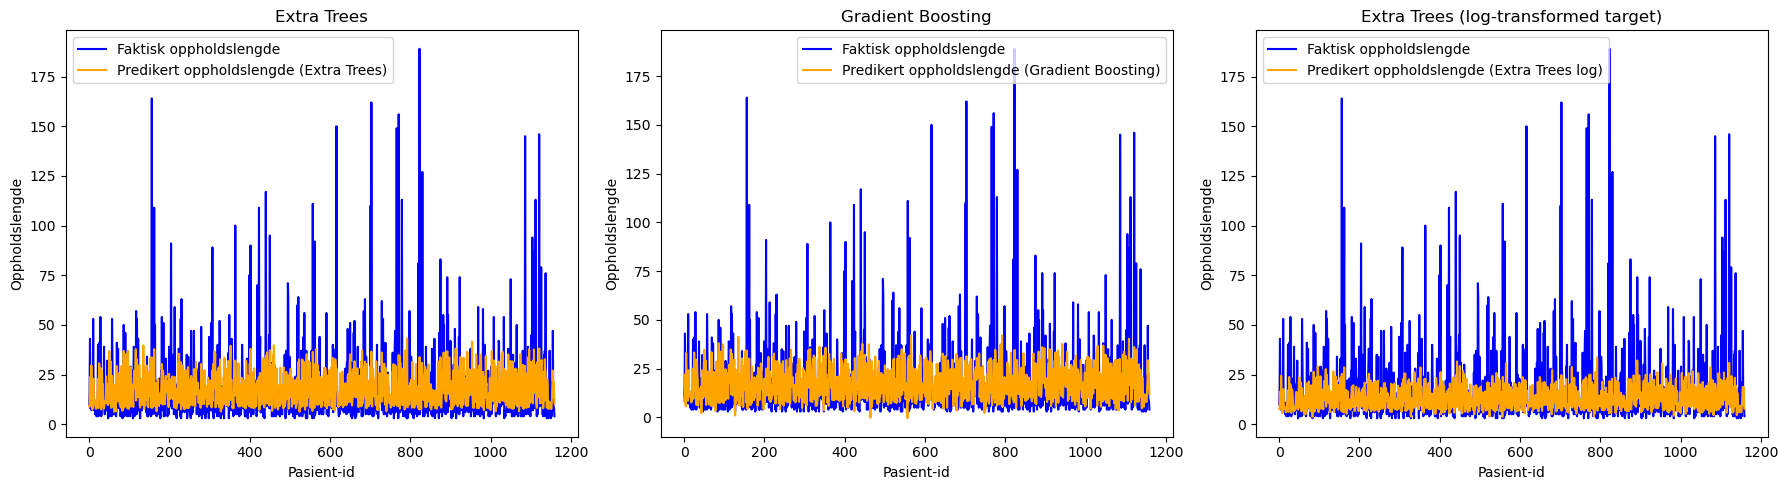

In [133]:
extraTrees_second.fit(X_train, y_train)
gradient_second.fit(X_train, y_train)
ExtraTree_log_second.fit(X_train, np.log(y_train))

y_pred_extraTrees = extraTrees_second.predict(X_val)
y_pred_gradient = gradient_second.predict(X_val)
y_pred_extraTrees_log_second = np.exp(ExtraTree_log_second.predict(X_val))

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(y_val, label='Faktisk oppholdslengde', color='blue')
plt.plot(y_pred_extraTrees, label='Predikert oppholdslengde (Extra Trees)', color='orange')
plt.title('Extra Trees')
plt.xlabel('Pasient-id')
plt.ylabel('Oppholdslengde')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(y_val, label='Faktisk oppholdslengde', color='blue')
plt.plot(y_pred_gradient, label='Predikert oppholdslengde (Gradient Boosting)', color='orange')
plt.title('Gradient Boosting')
plt.xlabel('Pasient-id')
plt.ylabel('Oppholdslengde')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(y_val, label='Faktisk oppholdslengde', color='blue')
plt.plot(y_pred_extraTrees_log_second, label='Predikert oppholdslengde (Extra Trees log)', color='orange')
plt.title('Extra Trees (log-transformed target)')
plt.xlabel('Pasient-id')
plt.ylabel('Oppholdslengde')
plt.legend()

plt.tight_layout()
plt.show()



#### 7.0.1 ExtraTree med test data. 

In [134]:
models = [extraTrees_second]
model_rmse = {} 


for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    

    model_rmse[model.__class__.__name__] = rmse

    print(f"{model.__class__.__name__} - RMSE: {rmse:.4f}")


best_model_name = min(model_rmse, key=model_rmse.get)
best_model = [model for model in models if model.__class__.__name__ == best_model_name][0]


print(f"\nBeste modell basert på RMSE på valideringssettet: {best_model_name} med RMSE: {model_rmse[best_model_name]:.4f}")

y_test_pred = best_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print(f"RMSE på testsettet: {test_rmse:.4f}")

ExtraTreesRegressor - RMSE: 18.4731

Beste modell basert på RMSE på valideringssettet: ExtraTreesRegressor med RMSE: 18.4731
RMSE på testsettet: 21.8203


In [135]:
pred_df = pd.DataFrame({'Value': y_test_pred, 'Type': 'Predicted'})
actual_df = pd.DataFrame({'Value': y_test, 'Type': 'Actual'})

combined_df = pd.concat([pred_df, actual_df])

fig = px.histogram(combined_df, x='Value', color='Type', opacity=0.6, barmode='overlay')

fig.update_layout(
    title='Predicted vs faktisk fordeling på testsettet',
    xaxis_title='Stay Duration',
    yaxis_title='Count'
)

fig.show()

#### Lagrer til nettside

In [136]:
import pickle


with open('model.pkl', 'wb') as model_file:
    pickle.dump(extraTrees_second, model_file)

model = pickle.load(open('model.pkl', 'rb'))
